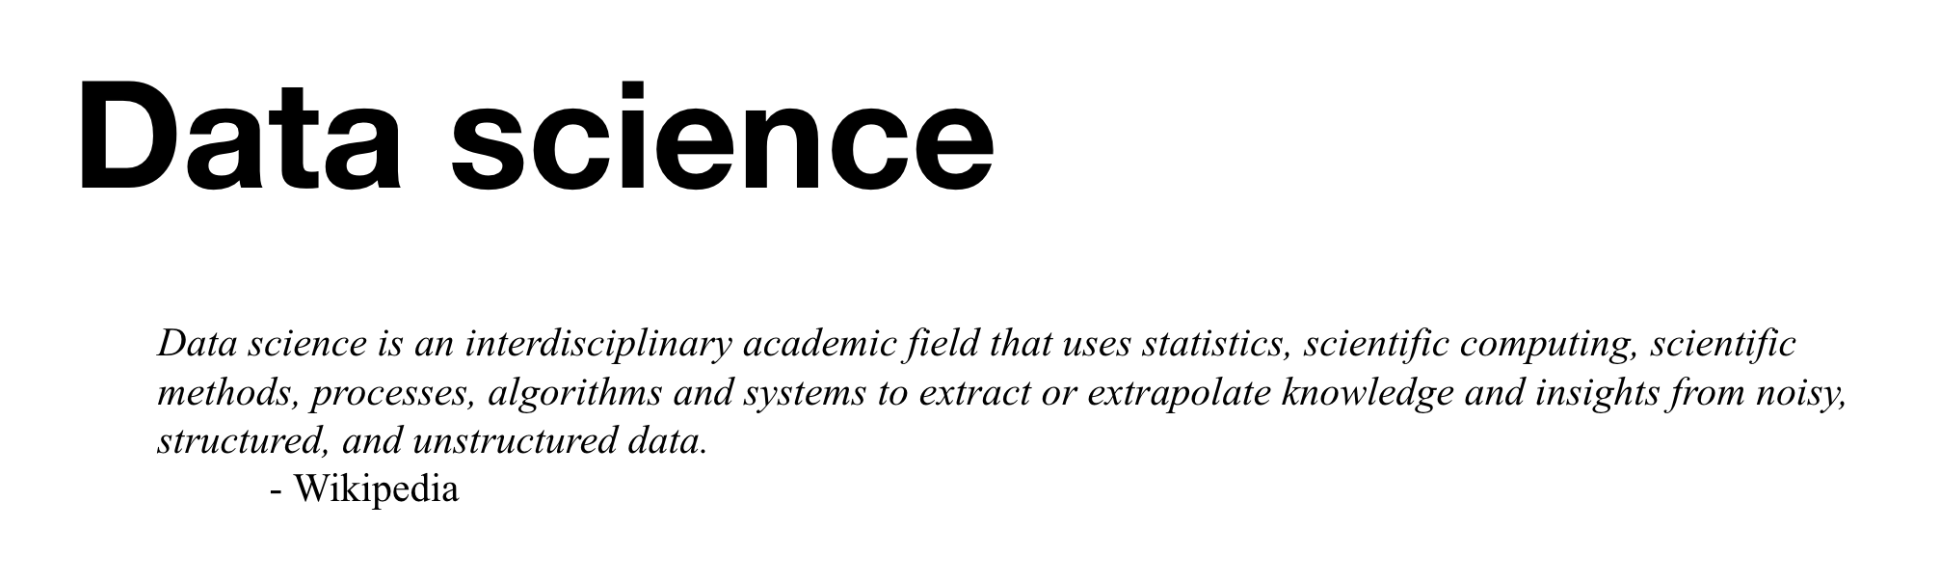

Inspired by: https://db.in.tum.de/teaching/ss19/moderndbs/duckdb-tum.pdf

## Data science seems like a prime target for RDBMS
- After all, it has “data” in the name!
- Data scientists work with data ⇒ Thus they need to manage that data!
- Yet, many data scientists do not use RDBMS… Instead of using RDBMS, they have invented their own solutions
    - They manage data using flat files
    - CSV files, binary, HDF5, parquet…
    - They created their own libraries for DBMS ops
    - dplyr, pandas, DataFrames (**python**)

## Flat file management
- Manually managing files is cumbersome
    - Loading and parsing e.g. CSV files is inefficient
    - File writers typically do not offer resiliency
    - Files can be corrupted
    - Difficult to change/update

**It does not scale!**



## dplyr, pandas, DataFrames - what is the problem?
- The problem is that they are very poor query engines!
    - No query optimizer
    - Not even for basics like filter pushdown
    - No support for out of memory computation
    - No support for parallelization
    - Unoptimized implementations for joins/aggregations

## SQLite ?
- SQLite has one problem: designed for OLTP
- No parallelization/vectorization

## Centrum Wiskunde & Informatica (CWI)

- Genetics researchers - 1TB of CSV files - loaded every time they ran an analysis

# DuckDB
### an in-process SQL OLAP database management system

*There are many database management systems (DBMS) out there. But there is no one-size-fits all database system. All take different trade-offs to better adjust to specific use cases. DuckDB is no different. Here, we try to explain what goals DuckDB has and why and how we try to achieve those goals through technical means. To start with, DuckDB is a relational (table-oriented) DBMS that supports the Structured Query Language (SQL).*

1. Fast Analytical Queries - complex, relatively long-running queries that process significant portions of the stored dataset
    - columnar-vectorized query execution engine - https://www.vldb.org/pvldb/vol11/p2209-kersten.pdf
2. Simple and Portable Deployment
   - just like SQLite - no external dependencies
   - no DBMS server software to install
   - embedded within a host process
   - high-speed data transfer - zero-copy (eg. run queries directly on Pandas data without ever importing or copying any data)
3. Integration
   - deeply integrated into ***Python*** and R (+ APIs for Java, C, C++, Julia, Swift, and others)
4. Thorough Testing - CI (https://github.com/duckdb/duckdb)
5. Free & Open Source License

6. https://duckdbsnippets.com/ - your favourite duckdb snippets!


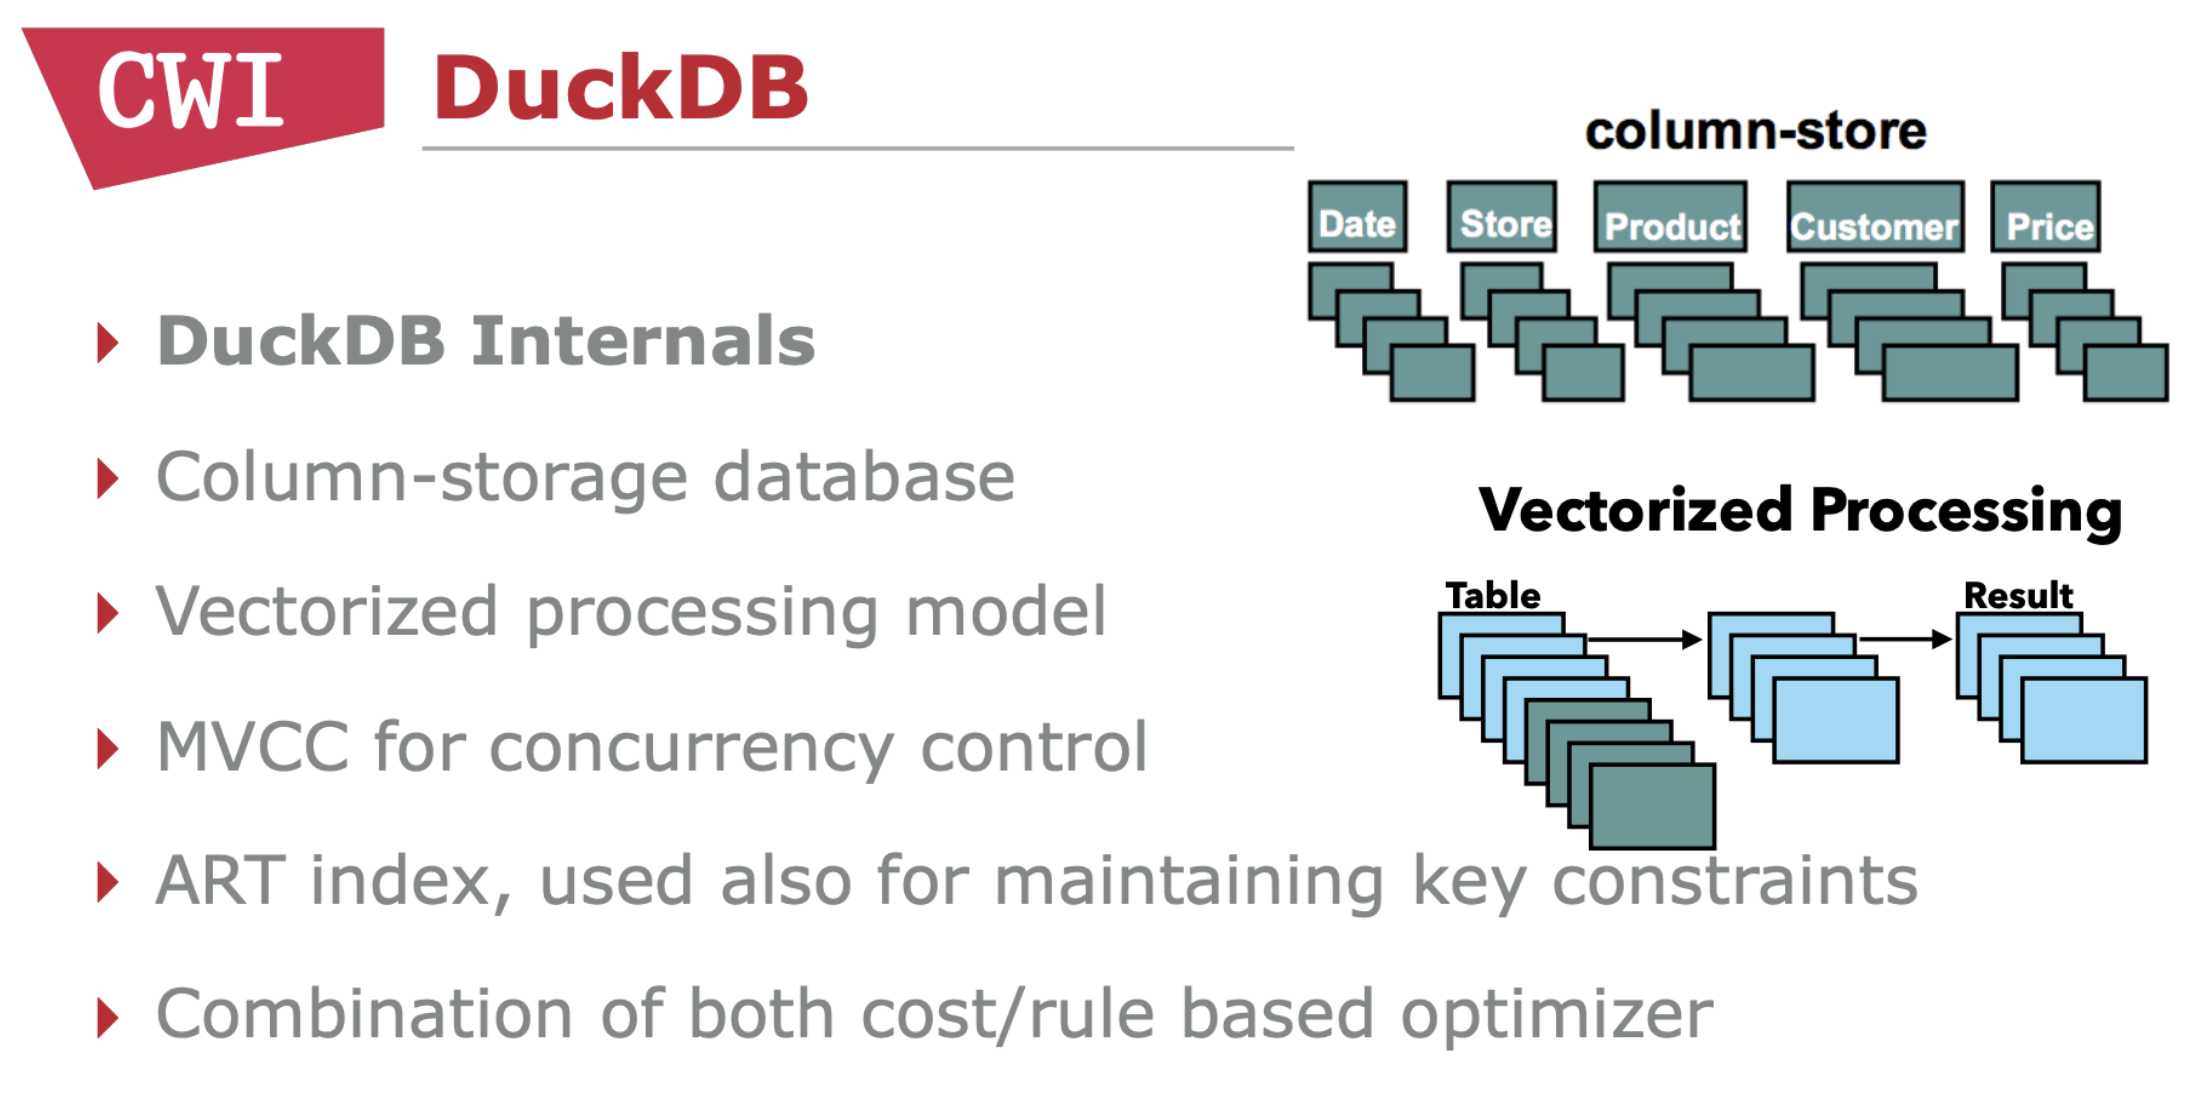

## Installation and data preparation stuff

In [1]:
# install sqlite3 locally
# !sudo apt install sqlite3 (or brew)

In [2]:
# !pip install duckdb pandas jupysql matplotlib duckdb-engine jupyterlab_execute_time seaborn pyarrow ipywidgets numpy

In [3]:
import duckdb
import pandas as pd

conn = duckdb.connect()

In [4]:
# Let's test whether we are up and running
conn.execute("SELECT 'Off and flying!' AS a_duckdb_column").df()

a_duckdb_column
0  Off and flying!

## The dataset

*The dataset from this benchmark was obtained from the actual traffic
recording of one of the world's largest web analytics platforms. It is
anonymized while keepingall the essential distributions of the data.
The set of queries was improvised to reflect the realistic workloads,
while the queries are not directly from production.* - ClickBench

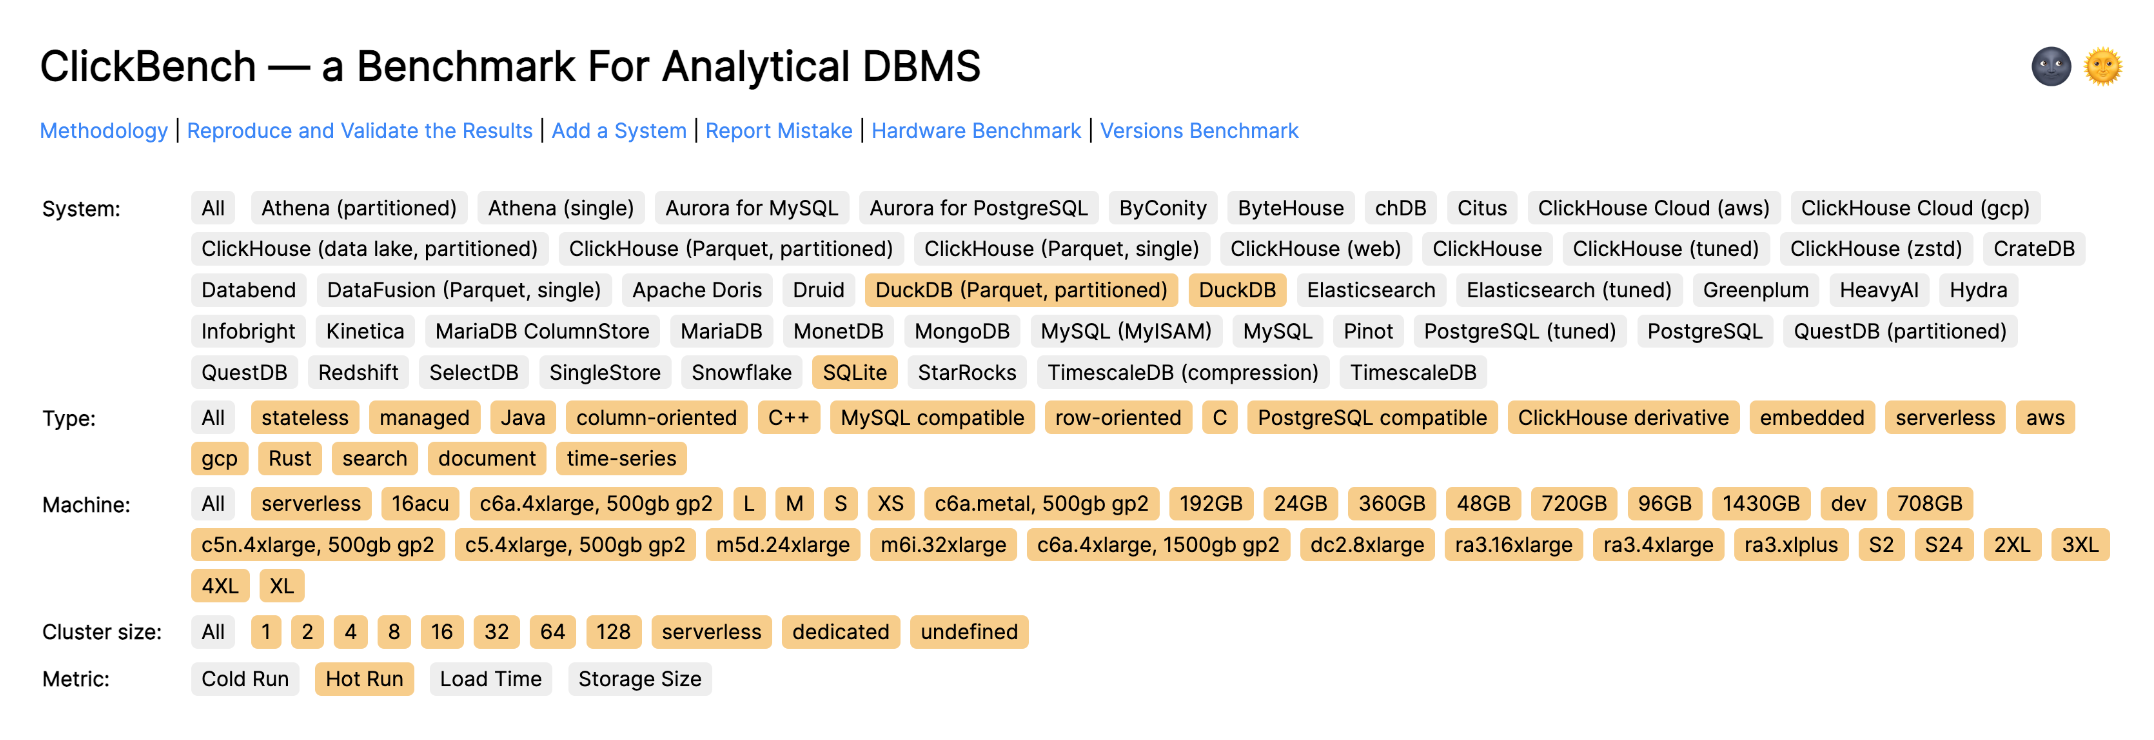

## The benchmark

url: https://benchmark.clickhouse.com/

source: https://github.com/ClickHouse/ClickBench

### ClickBench — a Benchmark For Analytical DBMS
*The benchmark was created in October 2013 to evaluate various DBMS to use for a web analytics system. It has been made by taking 1/50th of one week of production pageviews (a.k.a. "hits") data and taking the first one billion, one hundred million, and ten million records from it. It has been run on a 3-node cluster of Xeon E2650v2 with 128 GiB RAM, 8x6TB HDD in md-RAID-6, and 10 Gbit network in a private datacenter in Finland.* - https://github.com/ClickHouse/ClickBench/


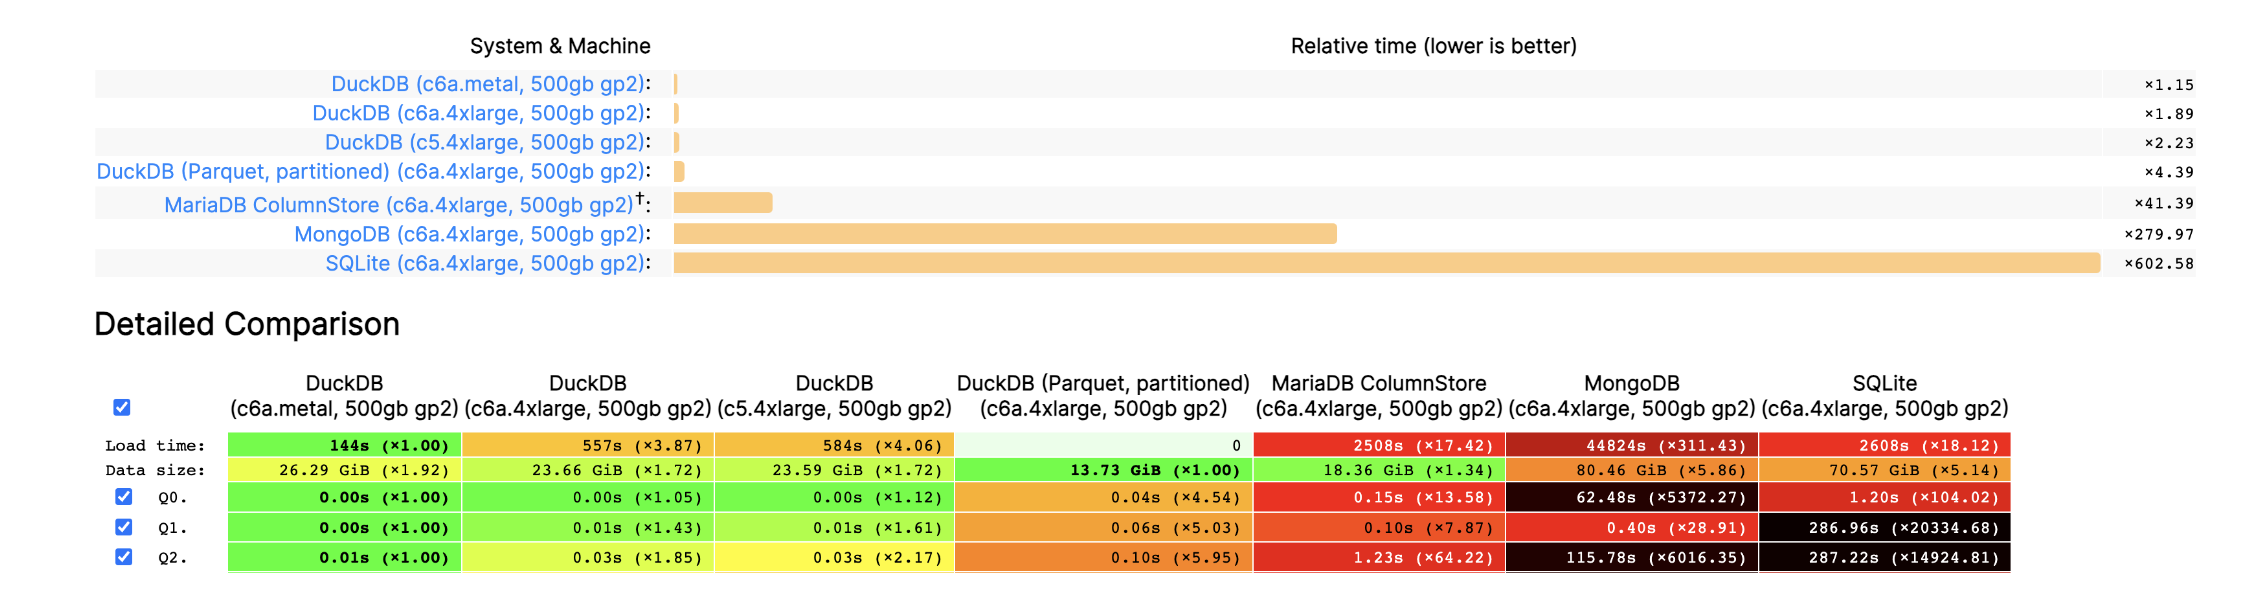

In [5]:
# Run this only once, dataset is quite huge (15 GB)
# !curl https://datasets.clickhouse.com/hits_compatible/hits.parquet --output hits.parquet
!ls -lah | grep -w "hits.parquet"

-rw-r--r--@  1 gkaretka  staff    14G Nov 20 09:53 hits.parquet


### Create subset of original dataset (eg. 5%) so we don't wait so long for SQLite

In [7]:
# take 5% of original dataset - creat new csv and parquet file
display("Creating 5% sized dataset ...")
conn.execute("SET enable_progress_bar=true") # show progressbar

# Run this if you are running this for the first time - can take longer
conn.execute("DROP TABLE IF EXISTS tmp_hits")
conn.execute("""CREATE TABLE tmp_hits AS
                    SELECT *
                       REPLACE (epoch_ms(EventTime * 1000) AS EventTime,
                       DATE '1970-01-01' + INTERVAL (EventDate) DAYS AS EventDate)
                   FROM read_parquet('hits.parquet', binary_as_string=True) USING SAMPLE 5%""")

# Run this if you already created small_hits.parquet
# conn.execute("DROP TABLE IF EXISTS tmp_hits")
# conn.execute("""
# CREATE TABLE tmp_hits AS
# SELECT *
#     --REPLACE (epoch_ms(EventTime * 1000) AS EventTime, DATE '1970-01-01' + INTERVAL (EventDate) DAYS AS EventDate)
# FROM read_parquet('small_hits.parquet', binary_as_string=True)
# """)

'Creating 5% sized dataset ...'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Supported formats? - YES (all of them!)

- Data Import and Export
  - CSV
  - JSON
  - Parquet
  - Excel Files with the Spatial Extension
- Data locations
  - HTTP(S)
  - S3
  - GCP
  - and of course local

In [8]:
display("Creating small csv dataset ...")
conn.execute("COPY (SELECT * FROM tmp_hits) TO 'small_hits.csv' (HEADER, DELIMITER ',')")
display("Creating small parquet dataset ...")
conn.execute("COPY (SELECT * FROM tmp_hits) TO 'small_hits.parquet' (FORMAT PARQUET)")
display("Creating small json dataset ...")
conn.execute("COPY (SELECT * FROM tmp_hits) TO 'small_hits.json'")
display("Done ...")

'Creating small csv dataset ...'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

'Creating small parquet dataset ...'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

'Creating small json dataset ...'

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

'Done ...'

In [14]:
!ls -lah | grep -w "small_hits.parquet"
!ls -lah | grep -w "small_hits.csv"
!ls -lah | grep -w "small_hits.json"

-rw-r--r--@  1 gkaretka  staff   698M Nov 30 10:54 small_hits.parquet
-rw-r--r--@  1 gkaretka  staff   3.5G Nov 30 10:54 small_hits.csv
-rw-r--r--@  1 gkaretka  staff    10G Nov 30 10:55 small_hits.json


### Let's do some quick queries on original 15GB data (and small dataset)

In [15]:
# Let's do some quick queries - on parquets
res = conn.execute("SELECT count(*) FROM 'hits.parquet'").df()
type(res)

pandas.core.frame.DataFrame

In [16]:
# Let's do some quick queries - on csv (reduced size dataset)
res = conn.execute("SELECT * FROM 'small_hits.csv' LIMIT 3").df()

In [17]:
# Let's do some quick queries - on json (reduced size dataset)
res = conn.execute("SELECT * FROM 'small_hits.json' LIMIT 3").df()

In [18]:
# Let's do some quick queries
conn.execute("DESCRIBE (SELECT * FROM 'hits.parquet' LIMIT 3)").df()

column_name column_type null   key default extra
0        WatchID      BIGINT  YES  None    None  None
1     JavaEnable    SMALLINT  YES  None    None  None
2          Title     VARCHAR  YES  None    None  None
3      GoodEvent    SMALLINT  YES  None    None  None
4      EventTime      BIGINT  YES  None    None  None
..           ...         ...  ...   ...     ...   ...
100      FromTag     VARCHAR  YES  None    None  None
101     HasGCLID    SMALLINT  YES  None    None  None
102  RefererHash      BIGINT  YES  None    None  None
103      URLHash      BIGINT  YES  None    None  None
104         CLID     INTEGER  YES  None    None  None

[105 rows x 6 columns]

## Cool, but can we visualize it? - YES!

Clickbench query 9:
```SQL
SELECT
    RegionID,
    SUM(AdvEngineID),
    COUNT(*) AS c,
    AVG(ResolutionWidth),
    COUNT(DISTINCT UserID)
FROM hits
GROUP BY RegionID
ORDER BY c DESC
LIMIT 10;
```


<Axes: xlabel='cduid', ylabel='avg_res'>

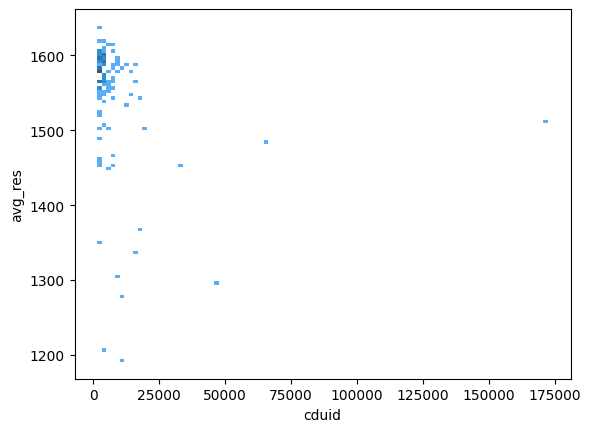

In [19]:
import seaborn as sns

df = conn.execute("""
SELECT
    RegionID,
    SUM(AdvEngineID) as sum,
    COUNT(*) AS c,
    AVG(ResolutionWidth) as avg_res,
    COUNT(DISTINCT UserID) as cduid
FROM tmp_hits
GROUP BY RegionID
ORDER BY c DESC
LIMIT 100
""").df()

sns.histplot(data=df, x="cduid", y="avg_res", bins=len(df['cduid']))

## Let's compare it to SQLite database with same but reduced data (5%)

In [20]:
# let's create sqlite db
import sqlite3
sqlite_con = sqlite3.connect("hits_sqlite.db")
sqlite_con.execute("DROP TABLE IF EXISTS hits")
sqlite_con.execute("""
CREATE TABLE IF NOT EXISTS hits
(
    WatchID BIGINT NOT NULL,
    JavaEnable SMALLINT NOT NULL,
    Title TEXT NOT NULL,
    GoodEvent SMALLINT NOT NULL,
    EventTime TIMESTAMP NOT NULL,
    EventDate Date NOT NULL,
    CounterID INTEGER NOT NULL,
    ClientIP INTEGER NOT NULL,
    RegionID INTEGER NOT NULL,
    UserID BIGINT NOT NULL,
    CounterClass SMALLINT NOT NULL,
    OS SMALLINT NOT NULL,
    UserAgent SMALLINT NOT NULL,
    URL TEXT NOT NULL,
    Referer TEXT NOT NULL,
    IsRefresh SMALLINT NOT NULL,
    RefererCategoryID SMALLINT NOT NULL,
    RefererRegionID INTEGER NOT NULL,
    URLCategoryID SMALLINT NOT NULL,
    URLRegionID INTEGER NOT NULL,
    ResolutionWidth SMALLINT NOT NULL,
    ResolutionHeight SMALLINT NOT NULL,
    ResolutionDepth SMALLINT NOT NULL,
    FlashMajor SMALLINT NOT NULL,
    FlashMinor SMALLINT NOT NULL,
    FlashMinor2 TEXT NOT NULL,
    NetMajor SMALLINT NOT NULL,
    NetMinor SMALLINT NOT NULL,
    UserAgentMajor SMALLINT NOT NULL,
    UserAgentMinor VARCHAR(255) NOT NULL,
    CookieEnable SMALLINT NOT NULL,
    JavascriptEnable SMALLINT NOT NULL,
    IsMobile SMALLINT NOT NULL,
    MobilePhone SMALLINT NOT NULL,
    MobilePhoneModel TEXT NOT NULL,
    Params TEXT NOT NULL,
    IPNetworkID INTEGER NOT NULL,
    TraficSourceID SMALLINT NOT NULL,
    SearchEngineID SMALLINT NOT NULL,
    SearchPhrase TEXT NOT NULL,
    AdvEngineID SMALLINT NOT NULL,
    IsArtifical SMALLINT NOT NULL,
    WindowClientWidth SMALLINT NOT NULL,
    WindowClientHeight SMALLINT NOT NULL,
    ClientTimeZone SMALLINT NOT NULL,
    ClientEventTime TIMESTAMP NOT NULL,
    SilverlightVersion1 SMALLINT NOT NULL,
    SilverlightVersion2 SMALLINT NOT NULL,
    SilverlightVersion3 INTEGER NOT NULL,
    SilverlightVersion4 SMALLINT NOT NULL,
    PageCharset TEXT NOT NULL,
    CodeVersion INTEGER NOT NULL,
    IsLink SMALLINT NOT NULL,
    IsDownload SMALLINT NOT NULL,
    IsNotBounce SMALLINT NOT NULL,
    FUniqID BIGINT NOT NULL,
    OriginalURL TEXT NOT NULL,
    HID INTEGER NOT NULL,
    IsOldCounter SMALLINT NOT NULL,
    IsEvent SMALLINT NOT NULL,
    IsParameter SMALLINT NOT NULL,
    DontCountHits SMALLINT NOT NULL,
    WithHash SMALLINT NOT NULL,
    HitColor CHAR NOT NULL,
    LocalEventTime TIMESTAMP NOT NULL,
    Age SMALLINT NOT NULL,
    Sex SMALLINT NOT NULL,
    Income SMALLINT NOT NULL,
    Interests SMALLINT NOT NULL,
    Robotness SMALLINT NOT NULL,
    RemoteIP INTEGER NOT NULL,
    WindowName INTEGER NOT NULL,
    OpenerName INTEGER NOT NULL,
    HistoryLength SMALLINT NOT NULL,
    BrowserLanguage TEXT NOT NULL,
    BrowserCountry TEXT NOT NULL,
    SocialNetwork TEXT NOT NULL,
    SocialAction TEXT NOT NULL,
    HTTPError SMALLINT NOT NULL,
    SendTiming INTEGER NOT NULL,
    DNSTiming INTEGER NOT NULL,
    ConnectTiming INTEGER NOT NULL,
    ResponseStartTiming INTEGER NOT NULL,
    ResponseEndTiming INTEGER NOT NULL,
    FetchTiming INTEGER NOT NULL,
    SocialSourceNetworkID SMALLINT NOT NULL,
    SocialSourcePage TEXT NOT NULL,
    ParamPrice BIGINT NOT NULL,
    ParamOrderID TEXT NOT NULL,
    ParamCurrency TEXT NOT NULL,
    ParamCurrencyID SMALLINT NOT NULL,
    OpenstatServiceName TEXT NOT NULL,
    OpenstatCampaignID TEXT NOT NULL,
    OpenstatAdID TEXT NOT NULL,
    OpenstatSourceID TEXT NOT NULL,
    UTMSource TEXT NOT NULL,
    UTMMedium TEXT NOT NULL,
    UTMCampaign TEXT NOT NULL,
    UTMContent TEXT NOT NULL,
    UTMTerm TEXT NOT NULL,
    FromTag TEXT NOT NULL,
    HasGCLID SMALLINT NOT NULL,
    RefererHash BIGINT NOT NULL,
    URLHash BIGINT NOT NULL,
    CLID INTEGER NOT NULL,
    PRIMARY KEY (CounterID, EventDate, UserID, EventTime, WatchID)
);
""")

In [21]:
!ls -lah | grep -w "hits_sqlite.db"

-rw-r--r--@  1 gkaretka  staff   3.5G Nov 30 10:57 hits_sqlite.db


In [22]:
# sqlite is persisted on disk - run this only once (avg. run ~2.5 min)
!sqlite3 hits_sqlite.db '.mode csv hits;' '.import --csv small_hits.csv hits'

In [23]:
sqlite_con.execute("SELECT count(*) FROM 'hits'").fetchall()

[(4910533,)]

In [24]:
# Let's do some quick queries - on parquets
conn.execute("SELECT count(*) FROM 'small_hits.parquet'").df()

count_star()
0       4910532

In [25]:
conn.execute("SELECT count(*) FROM tmp_hits").df()

count_star()
0       4910532

## Let's perform some basic analytical queries (ClickBench)

**Query 2**: SELECT SUM(AdvEngineID), COUNT(*), AVG(ResolutionWidth) FROM hits;

In [26]:
# clickhouse benchmark
conn.execute("SELECT SUM(AdvEngineID), COUNT(*), AVG(ResolutionWidth) FROM 'small_hits.parquet'").df()

sum(AdvEngineID)  count_star()  avg(ResolutionWidth)
0          358516.0       4910532           1514.476278

In [27]:
# On SQLite
sqlite_con.execute("SELECT SUM(AdvEngineID), COUNT(*), AVG(ResolutionWidth) FROM hits").fetchall()

[(358516.0, 4910533, 1514.4759693092378)]

**Query 12**: `SELECT SearchPhrase, COUNT(*) AS c FROM hits WHERE SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;`

In [28]:
res = conn.execute("""
    SELECT
        SearchPhrase,
        COUNT(*) AS c
    FROM 'small_hits.parquet'
    WHERE
        SearchPhrase <> ''
    GROUP BY
        SearchPhrase
    ORDER BY c DESC
    LIMIT 10
""").df()

In [29]:
res = conn.execute("""
    SELECT
        SearchPhrase,
        COUNT(*) AS c
    FROM tmp_hits
    WHERE
        SearchPhrase <> ''
    GROUP BY
        SearchPhrase
    ORDER BY c DESC
    LIMIT 10
""").df()

In [30]:
res = conn.execute("""
    SELECT
        SearchPhrase,
        COUNT(*) AS c
    FROM 'hits.parquet'
    WHERE
        SearchPhrase <> ''
    GROUP BY
        SearchPhrase
    ORDER BY c DESC
    LIMIT 10
""").df()

In [31]:
res = sqlite_con.execute("""
SELECT
    SearchPhrase,
    COUNT(*) AS c
FROM hits
WHERE
    SearchPhrase <> ''
GROUP BY
    SearchPhrase
ORDER BY c DESC
LIMIT 10
""").fetchall()

## Querying pandas datasets (zero-copy magic)

We can do some pretty complex queries with duckdb right on dataframes. These queries are performed without copying the data.

Query 35:
```SQL
SELECT ClientIP, ClientIP - 1, ClientIP - 2, ClientIP - 3, COUNT(*) AS c FROM hits GROUP BY ClientIP, ClientIP - 1, ClientIP - 2, ClientIP - 3 ORDER BY c DESC LIMIT 10;
```

Query 42:
```SQL
SELECT DATE_TRUNC('minute', EventTime) AS M, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-14' AND EventDate <= '2013-07-15' AND IsRefresh = 0 AND DontCountHits = 0 GROUP BY DATE_TRUNC('minute', EventTime) ORDER BY DATE_TRUNC('minute', EventTime) LIMIT 10 OFFSET 1000;
```

In [32]:
small_hits_df = pd.read_parquet("small_hits.parquet")

In [33]:
res = conn.execute("""
    SELECT  ClientIP,
            ClientIP - 1,
            ClientIP - 2,
            ClientIP - 3,
            COUNT(*) AS c
    FROM small_hits_df
    GROUP BY
        ClientIP,
        ClientIP - 1,
        ClientIP - 2,
        ClientIP - 3
    ORDER BY c DESC
    LIMIT 10""")
res.df().head(3)

ClientIP  (ClientIP - 1)  (ClientIP - 2)  (ClientIP - 3)     c
0   -39921974       -39921975       -39921976       -39921977  2392
1 -2110973377     -2110973378     -2110973379     -2110973380  1463
2  1261575448      1261575447      1261575446      1261575445  1376

In [34]:
res = conn.execute("""
    SELECT
        DATE_TRUNC('minute', EventTime) AS M,
        COUNT(*) AS PageViews
    FROM small_hits.parquet
    WHERE
        CounterID = 62
        AND EventDate >= '2013-07-14'
        AND EventDate <= '2013-07-15'
        AND IsRefresh = 0
        AND DontCountHits = 0
    GROUP BY
        DATE_TRUNC('minute', EventTime)
    ORDER BY
        DATE_TRUNC('minute', EventTime)
    LIMIT 10
    OFFSET 1000;""")
res.df().head(3)

M  PageViews
0 2013-07-15 12:40:00         27
1 2013-07-15 12:41:00         16
2 2013-07-15 12:42:00         21

In [35]:
res = conn.execute("""
    SELECT
        DATE_TRUNC('minute', EventTime) AS M,
        COUNT(*) AS PageViews
    FROM small_hits_df
    WHERE
        CounterID = 62
        AND EventDate >= '2013-07-14'
        AND EventDate <= '2013-07-15'
        AND IsRefresh = 0
        AND DontCountHits = 0
    GROUP BY
        DATE_TRUNC('minute', EventTime)
    ORDER BY
        DATE_TRUNC('minute', EventTime)
    LIMIT 10
    OFFSET 1000;""")
res.df().head(3)

M  PageViews
0 2013-07-15 12:40:00         27
1 2013-07-15 12:41:00         16
2 2013-07-15 12:42:00         21

In [36]:
res = conn.execute("""
    SELECT
        DATE_TRUNC('minute', EventTime) AS M,
        COUNT(*) AS PageViews
    FROM tmp_hits
    WHERE
        CounterID = 62
        AND EventDate >= '2013-07-14'
        AND EventDate <= '2013-07-15'
        AND IsRefresh = 0
        AND DontCountHits = 0
    GROUP BY
        DATE_TRUNC('minute', EventTime)
    ORDER BY
        DATE_TRUNC('minute', EventTime)
    LIMIT 10
    OFFSET 1000;""")
res.df().head(3)

M  PageViews
0 2013-07-15 12:40:00         27
1 2013-07-15 12:41:00         16
2 2013-07-15 12:42:00         21

## Multiple files
source: https://opendata.bratislava.sk/dataset/show/zmluvy-olo

ZMLUVY ODVOZU A LIKVIDÁCIE ODPADU BRATISLAVA (OLO)

In [37]:
!curl https://opendata.bratislava.sk/dataset/download/zmluvy-olo/25 -o data0.csv
!curl https://opendata.bratislava.sk/dataset/download/zmluvy-olo/26 -o data1.csv
!curl https://opendata.bratislava.sk/dataset/download/zmluvy-olo/27 -o data2.csv
!curl https://opendata.bratislava.sk/dataset/download/zmluvy-olo/28 -o data3.csv
!ls -lah | grep "data[0,1,2,3].csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     02486  100  2486    0     0   6130      0 --:--:-- --:--:-- --:--:--  6184
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2430  100  2430    0     0   7046      0 --:--:-- --:--:-- --:--:--  7126
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4766  100  4766    0     0  13620      0 --:--:-- --:--:-- --:--:-- 13895
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:

In [38]:
conn.execute("""
    DESCRIBE (SELECT * FROM 'data*.csv');
""").df()

column_name column_type null   key default extra
0     column0     VARCHAR  YES  None    None  None
1     column1     VARCHAR  YES  None    None  None
2     column2     VARCHAR  YES  None    None  None
3     column3     VARCHAR  YES  None    None  None
4     column4     VARCHAR  YES  None    None  None
5     column5     VARCHAR  YES  None    None  None
6     column6     VARCHAR  YES  None    None  None

In [39]:
conn.execute("""
    SELECT * FROM 'data*.csv';
""").df()

column0  \
0                                                 ...   
1                                               číslo   
2                                           127-10-23   
3                                           128-50-23   
4                                           129-70-23   
..                                                ...   
93                                           95-10-23   
94                                           96-10-23   
95                                           97-50-23   
96                                           98-12-23   
97                                          100-10-23   

                                        column1                       column2  \
0                                          None                          None   
1                                    typ zmluvy                       partner   
2                           Zmluva o spolupráci          Rybársky klub KRAKEN   
3   Zmluva na výkon činnosti stavebného dozoru                    Juno s.r.o.   
4                                Zmluva o dielo           ELHYCO spol. s r.o.   
..                                          ...                           ...   
93                          Zmluva o spolupráci              KULTURISE s.r.o.   
94                          Zmluva o spolupráci              KULTURISE s.r.o.   
95                       Rámcová zmluva o dielo  TERMOSTAV Bratislava, s.r.o.   
96                       Rámcová zmluva o dielo             AUTO ROTOS s.r.o.   
97                          Zmluva o spolupráci    BUBO Travel Agency, s.r.o.   

                                              column3    column4  \
0                                                None       None   
1                                             predmet  podpísaná   
2     OLO ako partner na podujatí Vráťme ryby do vody  5.10.2023   
3   Výkon stavebno-technického dozoru stavebníka n...  2.10.2023   
4   Projekčné služby - projektové štúdie, dokument...  5.10.2023   
..                                                ...        ...   
93  OLO ako partner na podujatí Uprising festival ...  15.8.2023   
94  OLO ako partner na podujatí Uprising festival ...  11.8.2023   
95    Opravy žiaruvzdorných výmuroviek kotlov K1, K2   17.8.2023   
96  Servis služobných osobných motorových vozidiel...  22.8.2023   
97  OLO ako partner na podujatí Plávanie cez Dunaj...  25.8.2023   

                   column5      column6  
0                     None         None  
1                   sadzba  platnosť do  
2                     None    9.10.2023  
3      9.000,- EUR bez DPH         None  
4     16.200,- EUR bez DPH    3 mesiace  
..                     ...          ...  
93                    None         None  
94                    None    31.8.2023  
95  678.421,00 EUR bez DPH  24 mesiacov  
96   40.000,00 EUR bez DPH  24 mesiacov  
97                    None     4.9.2023  

[98 rows x 7 columns]

In [40]:
conn.execute("""
    SELECT * 
    FROM 'data*.csv'
    WHERE
        column2='Rybársky klub KRAKEN'
        OR column2='KULTURISE s.r.o.';
""").df()

column0              column1               column2  \
0  127-10-23  Zmluva o spolupráci  Rybársky klub KRAKEN   
1   95-10-23  Zmluva o spolupráci      KULTURISE s.r.o.   
2   96-10-23  Zmluva o spolupráci      KULTURISE s.r.o.   

                                             column3    column4 column5  \
0    OLO ako partner na podujatí Vráťme ryby do vody  5.10.2023    None   
1  OLO ako partner na podujatí Uprising festival ...  15.8.2023    None   
2  OLO ako partner na podujatí Uprising festival ...  11.8.2023    None   

     column6  
0  9.10.2023  
1       None  
2  31.8.2023

In [41]:
conn.execute("""
    SELECT DISTINCT(column2)
    FROM 'data*.csv'
    WHERE
        column5 IS NULL
        AND length(column1) > 1
""").df()

column2
0   KOOPERATIVA poisťovňa, a.s. Vienna Insurance G...
1                           Bratislava - inline, o.z.
2                                       OZ Živé Račko
3                            Spojená škola sv. Uršule
4                 Allianz - Slovenská poisťovňa, a.s.
5                                     BE COOL, s.r.o.
6                    Dopravný podnik Bratislava, a.s.
7              Bratislavský zväz malého futbalu, o.z.
8                                 Miroslava Petrášová
9                                    KULTURISE s.r.o.
10                               Rybársky klub KRAKEN
11       Bratislavské kultúrne a informačné stredisko
12                            Dúhový PRIDE Bratislava
13                  Základná škola s materskou školou
14                                    BIELA NOC, o.z.
15                         BUBO Travel Agency, s.r.o.

In [42]:
!curl https://opendata.bratislava.sk/dataset/download/index-ekonomickej-zavislosti-mladych-ludi/1 -o iezml.csv
!curl https://opendata.bratislava.sk/dataset/download/index-ekonomickej-zavislosti-starych-ludi/1 -o iezsl.csv
!iconv -f Windows-1250 -t ascii//TRANSLIT iezml.csv > iezml_ascii.csv
!iconv -f Windows-1250 -t ascii//TRANSLIT iezsl.csv > iezsl_ascii.csv
!ls -lah | grep "iez[m,s]l.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18306  100 18306    0     0  40953      0 --:--:-- --:--:-- --:--:-- 41229
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18255  100 18255    0     0  51752      0 --:--:-- --:--:-- --:--:-- 52157
-rw-r--r--@  1 gkaretka  staff    18K Nov 30 11:02 iezml.csv
-rw-r--r--@  1 gkaretka  staff    18K Nov 30 11:02 iezsl.csv


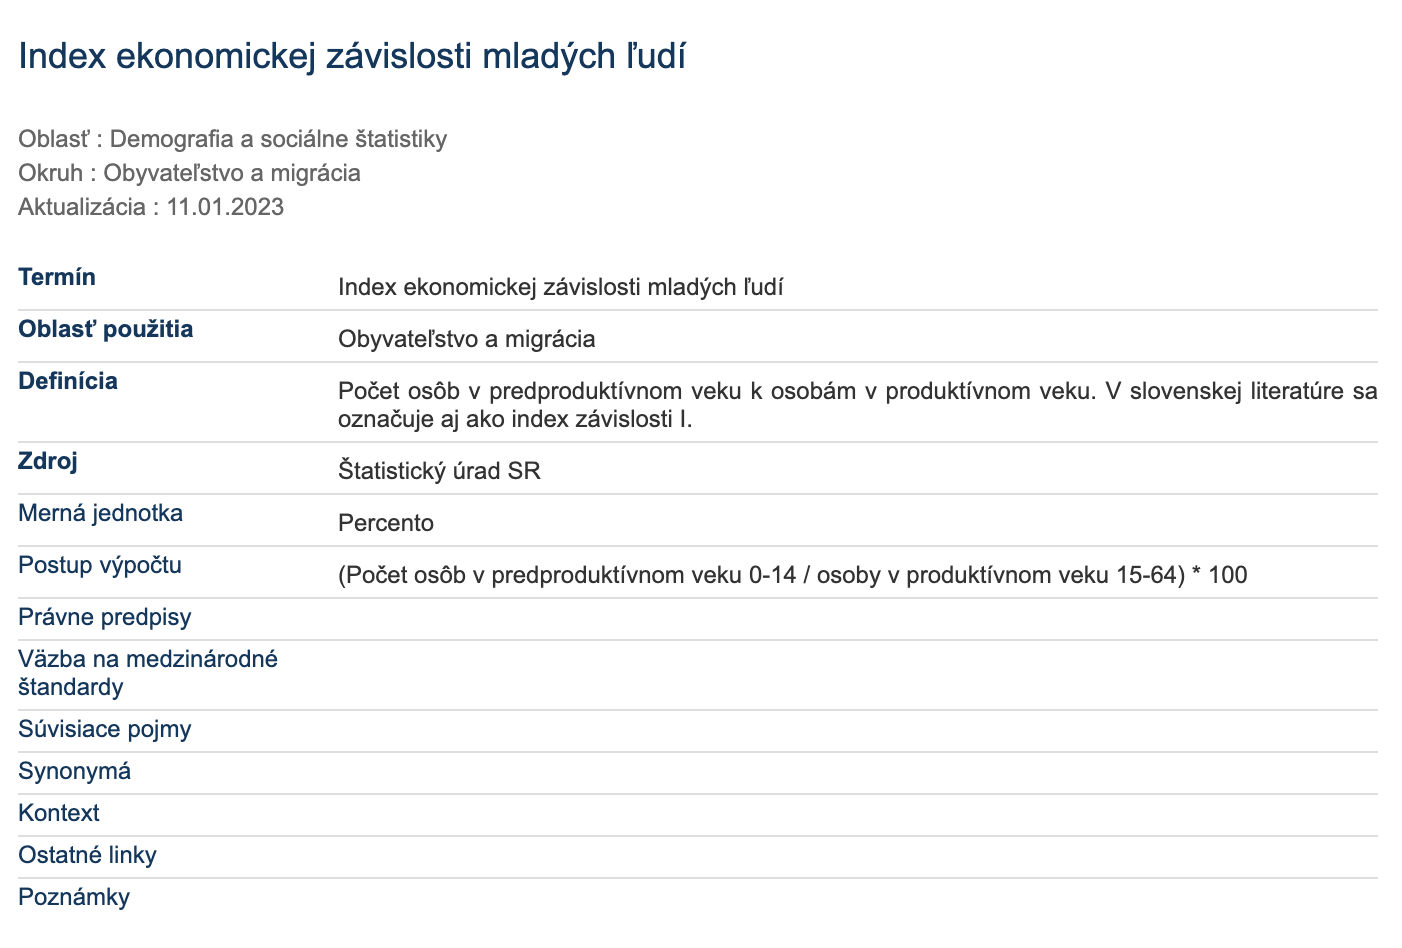

source: https://slovak.statistics.sk/PACVPEM/vocabPagesDetails.html?id=3074&lang=sk

In [43]:
res = conn.execute("""
    SELECT *
    FROM read_csv_auto('iezml_ascii.csv', delim=';', header=true)
""").df()

res_sl = conn.execute("""
    SELECT *
    FROM read_csv_auto('iezsl_ascii.csv', delim=';', header=true)
""").df()

res['mc'] = res["Mestsk'a cast"]
res['iezml'] = res["Index ekonomickej z'avislosti mlad'ych lud'i (Percento)"]
res['iezsl'] = res_sl["Index ekonomickej z'avislosti star'ych lud'i (Percento)"]
res.head()

Okres  Mestsk'a cast   Rok  \
0   Bratislava I   Star'e Mesto  2021   
1   Bratislava I   Star'e Mesto  2020   
2   Bratislava I   Star'e Mesto  2019   
3   Bratislava I   Star'e Mesto  2018   
4   Bratislava I   Star'e Mesto  2017   

  Index ekonomickej z'avislosti mlad'ych lud'i (Percento)             mc  \
0                                              24,25        Star'e Mesto   
1                                                 27        Star'e Mesto   
2                                              26,43        Star'e Mesto   
3                                              25,34        Star'e Mesto   
4                                              24,32        Star'e Mesto   

   iezml  iezsl  
0  24,25  33,86  
1     27   34,2  
2  26,43   33,9  
3  25,34  33,63  
4  24,32  33,08

In [44]:
import numpy as np
iezml = np.float64(res['iezml'].apply(lambda x: x.replace(",", ".")))
iezsl = np.float64(res['iezsl'].apply(lambda x: x.replace(",", ".")))

iezml_min = min(iezml)
iezml_max = max(iezml)

iezsl_min = min(iezsl)
iezsl_max = max(iezsl)

all_min = min([iezml_min, iezsl_min])
all_max = max([iezml_max, iezsl_max])

res['iezml'] = iezml
res['iezsl'] = iezsl

(5.59, 50.12)

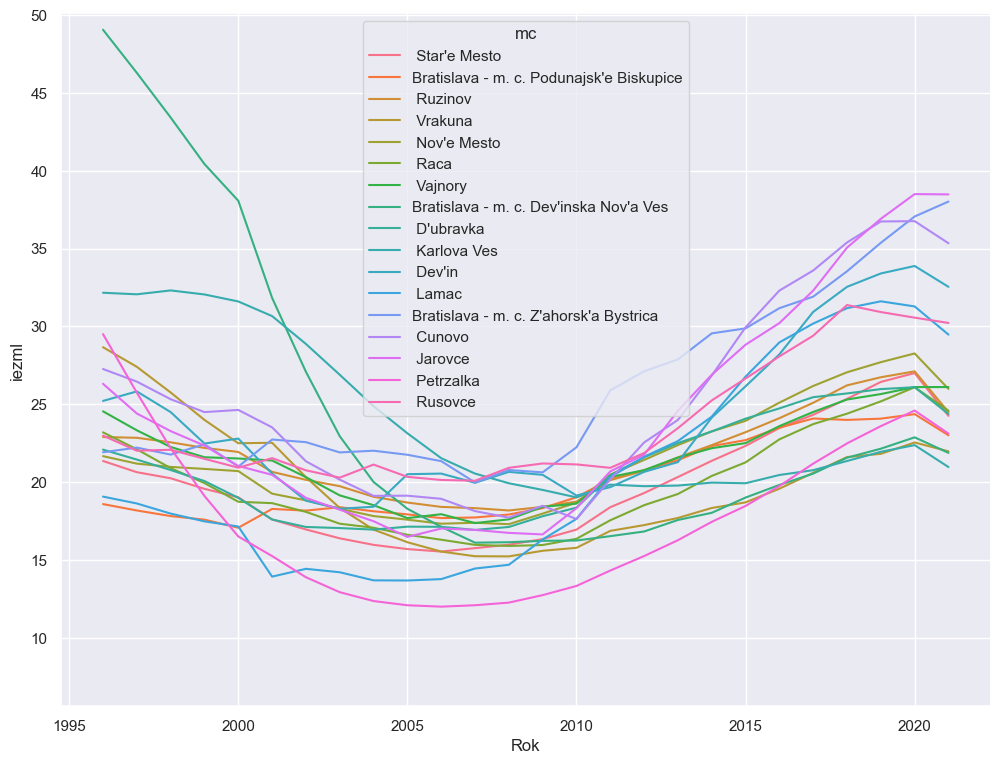

In [45]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12, 9)})

sns.lineplot(data=res, x="Rok", y="iezml", hue="mc")

# ax2 = plt.twinx()
# sns.lineplot(data=res, x="Rok", y="iezsl", hue="mc", ax=ax2)

plt.ylim([all_min, all_max])

<Axes: xlabel='Rok', ylabel='iezsl'>

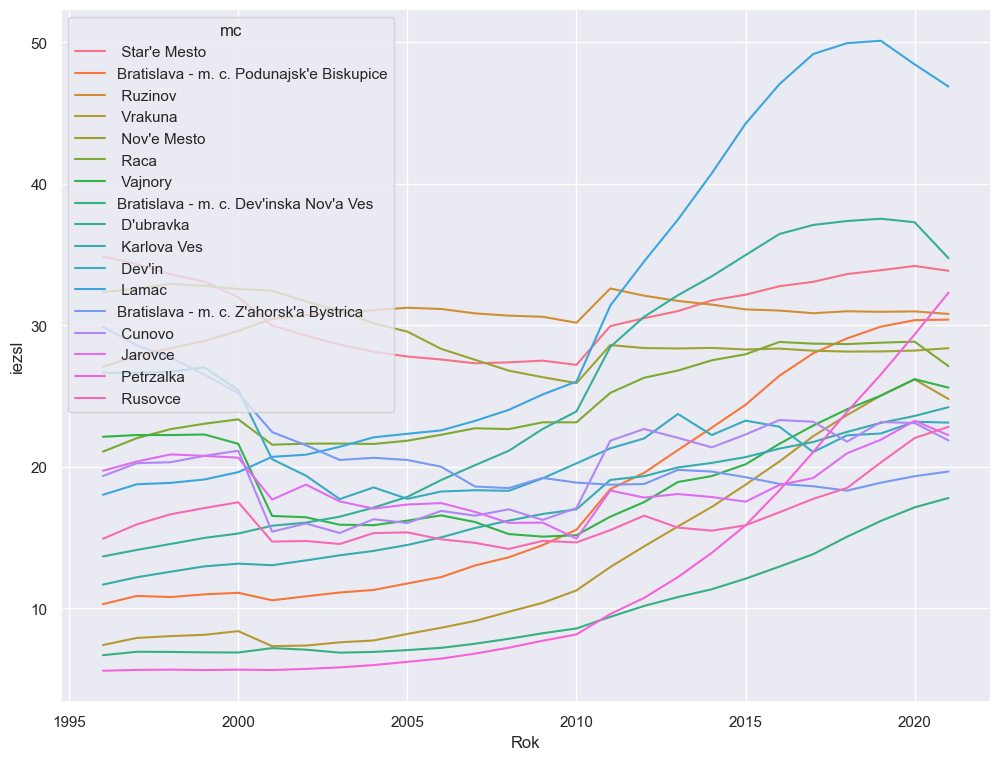

In [46]:
sns.lineplot(data=res, x="Rok", y="iezsl", hue="mc")

## Some other cool stuff
https://harlequin.sh/ - The DuckDB IDE for Your Terminal.

- View tables, columns, and their types across one or more attached databases.
- A full-featured editor: open, save, format, cut, copy, paste, and more. Supports multiple tabbed buffers!
- View up to 10k results in an interactive table. Multiple queries loaded into separate tabs.
- Connect to any **MotherDuck** database in local or SaaS mode.
- Need more room? Press F10 to view the Editor or Results in full-screen mode.
- Export query results and configure the export using a helpful UI.

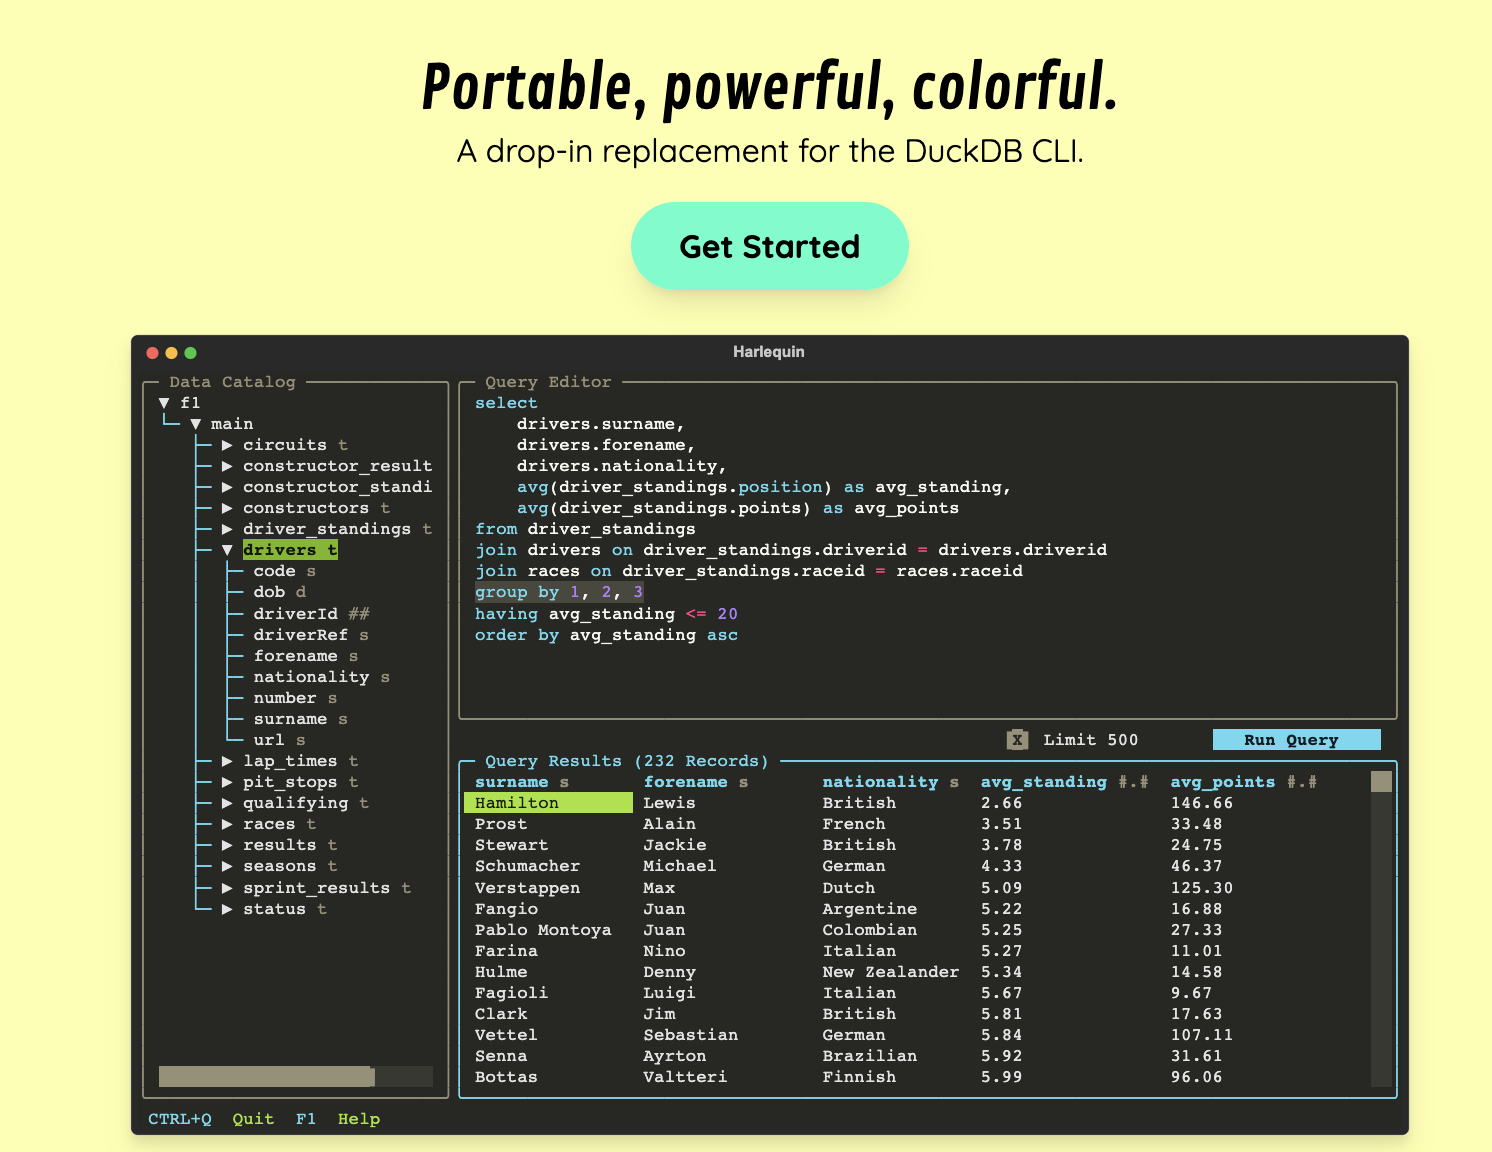

source: https://motherduck.com/
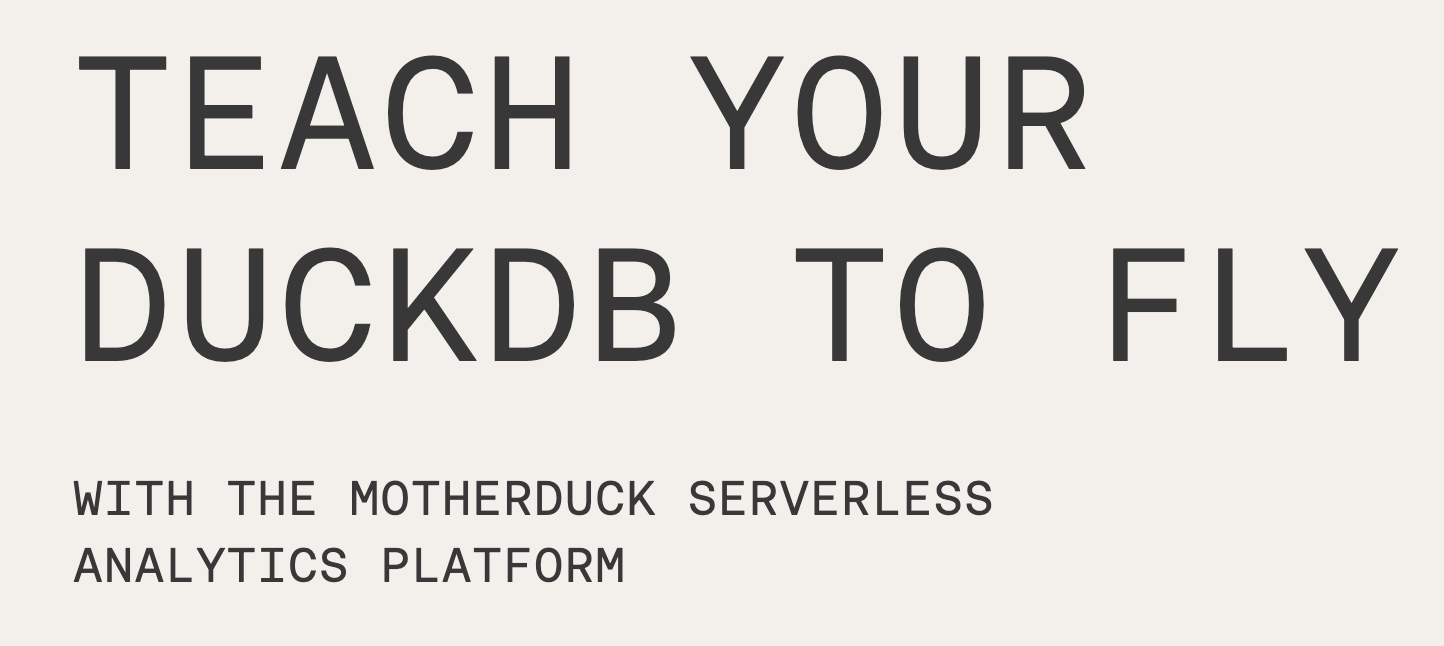
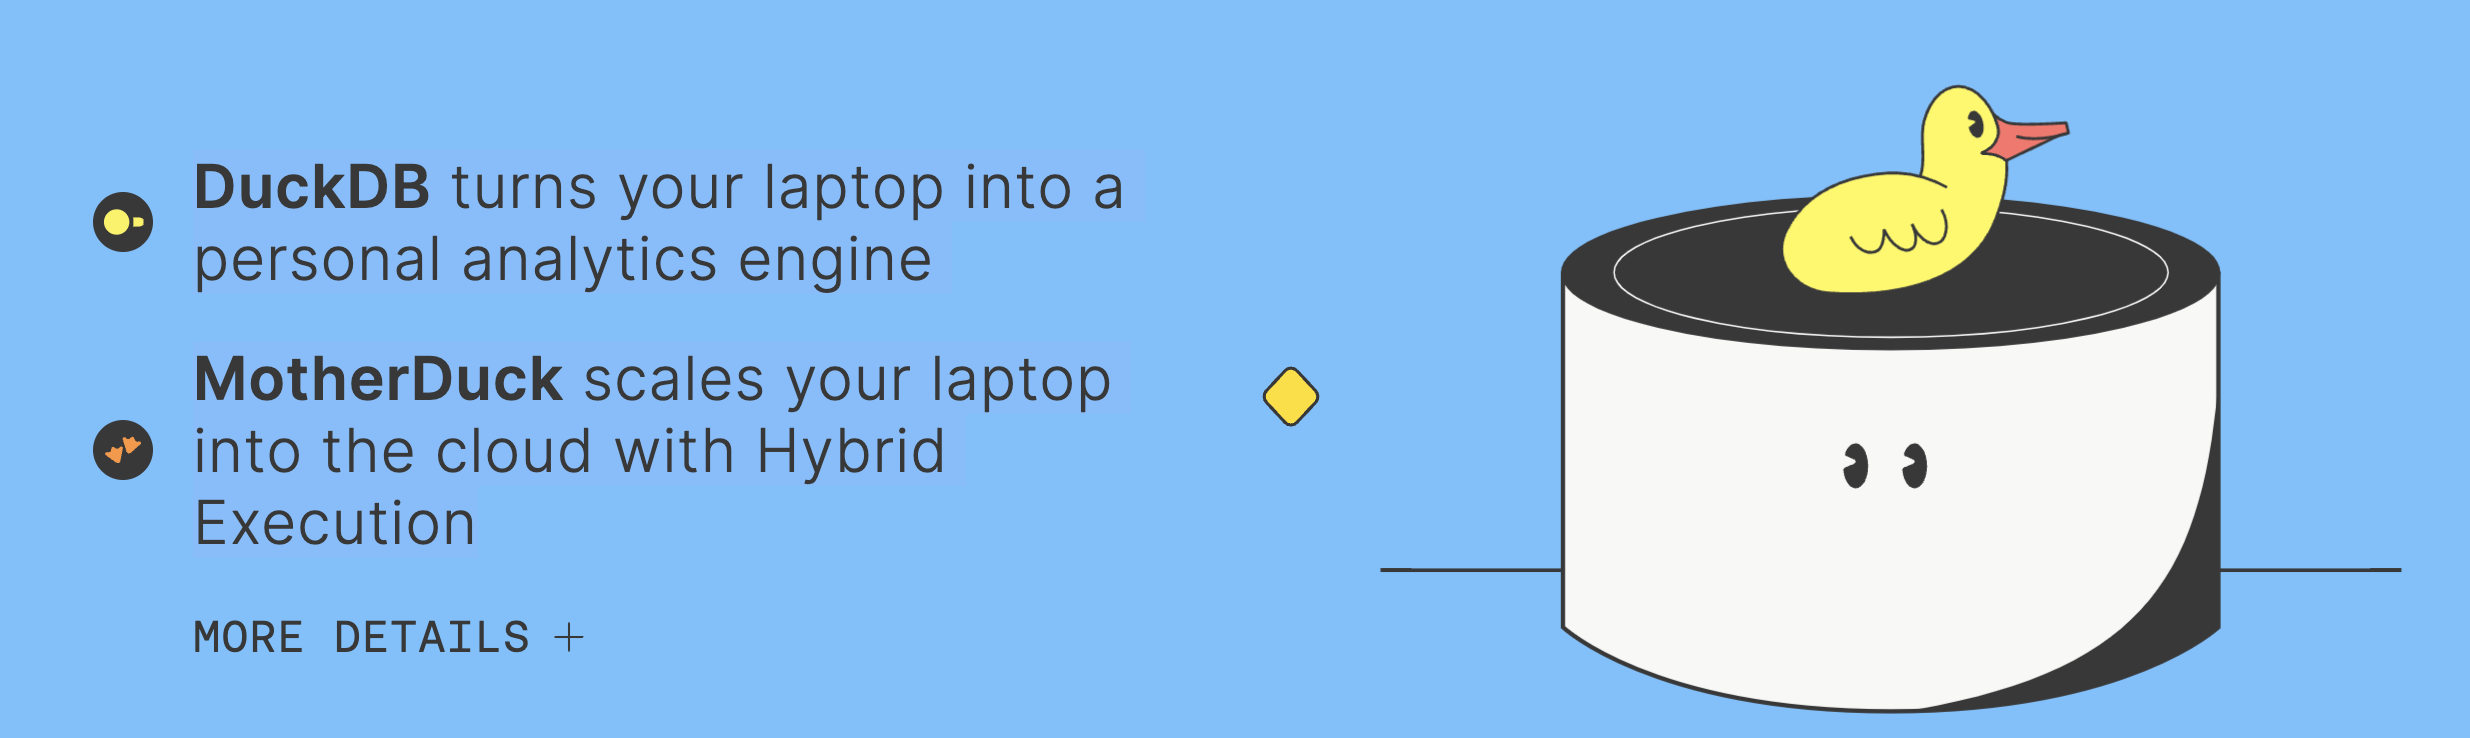

## DuckDB Wasm

source: https://duckdb.org/docs/api/wasm/overview.html

demo: https://shell.duckdb.org/

```SQL
CREATE TABLE weather (
    city    VARCHAR,
    temp_lo INTEGER, -- minimum temperature on a day
    temp_hi INTEGER, -- maximum temperature on a day
    prcp    REAL,
    date    DATE
);
```

```SQL
INSERT INTO weather VALUES ('San Francisco', 46, 50, 0.25, '1994-11-27');
```

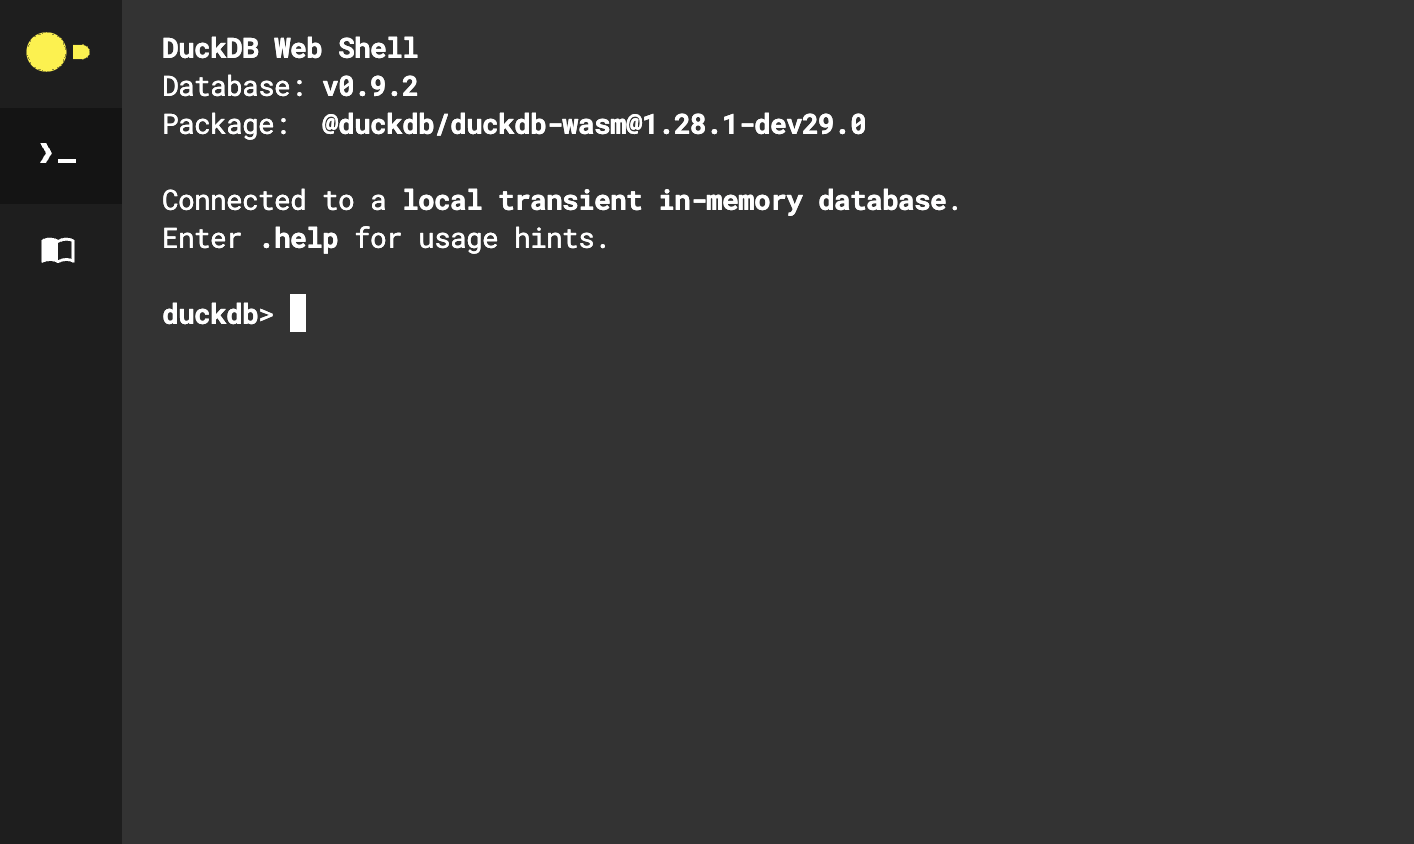

## Using SqlMagic

In [47]:
%load_ext sql
%sql conn --alias duckdb

In [48]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [49]:
# Let's test whether we are up and running
%sql SELECT 'Off and flying!' AS a_duckdb_column

a_duckdb_column
0  Off and flying!

In [50]:
%sql SELECT \
        DATE_TRUNC('minute', EventTime) AS M, \
        COUNT(*) AS PageViews \
    FROM small_hits.parquet \
    WHERE \
        CounterID = 62 \
        AND EventDate >= '2013-07-14' \
        AND EventDate <= '2013-07-15' \
        AND IsRefresh = 0 \
        AND DontCountHits = 0 \
    GROUP BY \
        DATE_TRUNC('minute', EventTime) \
    ORDER BY \
        DATE_TRUNC('minute', EventTime) \
    LIMIT 10 \
    OFFSET 1000

M  PageViews
0 2013-07-15 12:40:00         27
1 2013-07-15 12:41:00         16
2 2013-07-15 12:42:00         21
3 2013-07-15 12:43:00         26
4 2013-07-15 12:44:00         28
5 2013-07-15 12:45:00         28
6 2013-07-15 12:46:00         23
7 2013-07-15 12:47:00         18
8 2013-07-15 12:48:00         21
9 2013-07-15 12:49:00         15

<Axes: title={'center': "'iezsl' from 'res'"}, xlabel='iezsl', ylabel='Count'>

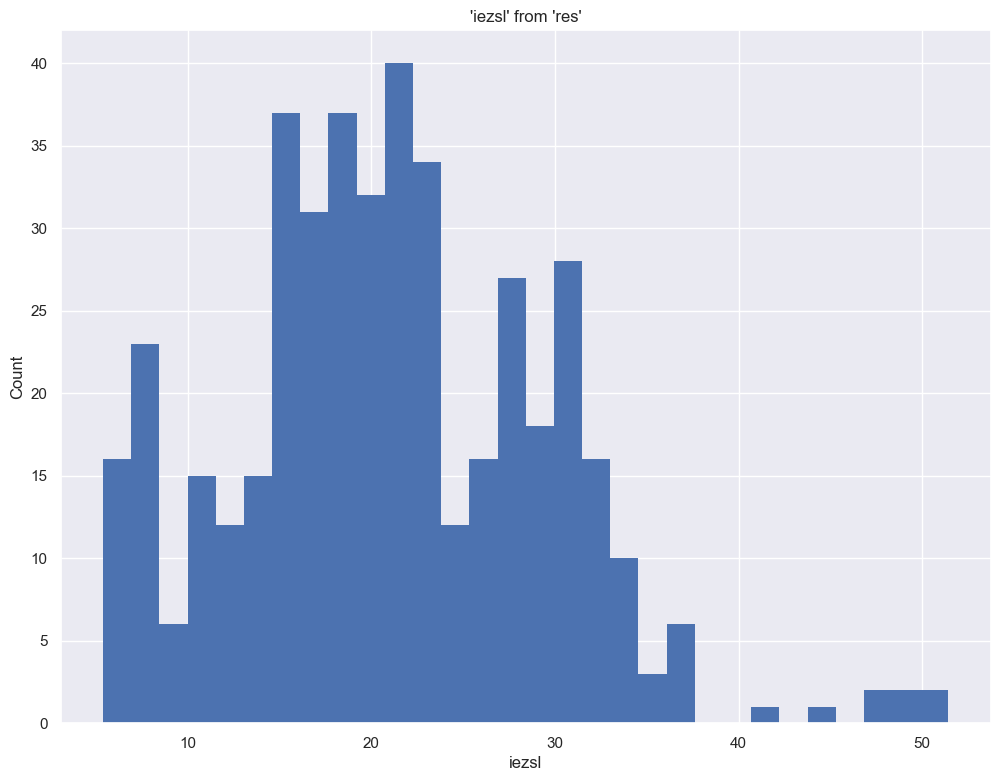

In [51]:
%sqlplot histogram --table res --column iezsl --bins 30

<Axes: title={'center': "'iezml' from 'res'"}, xlabel='iezml', ylabel='Count'>

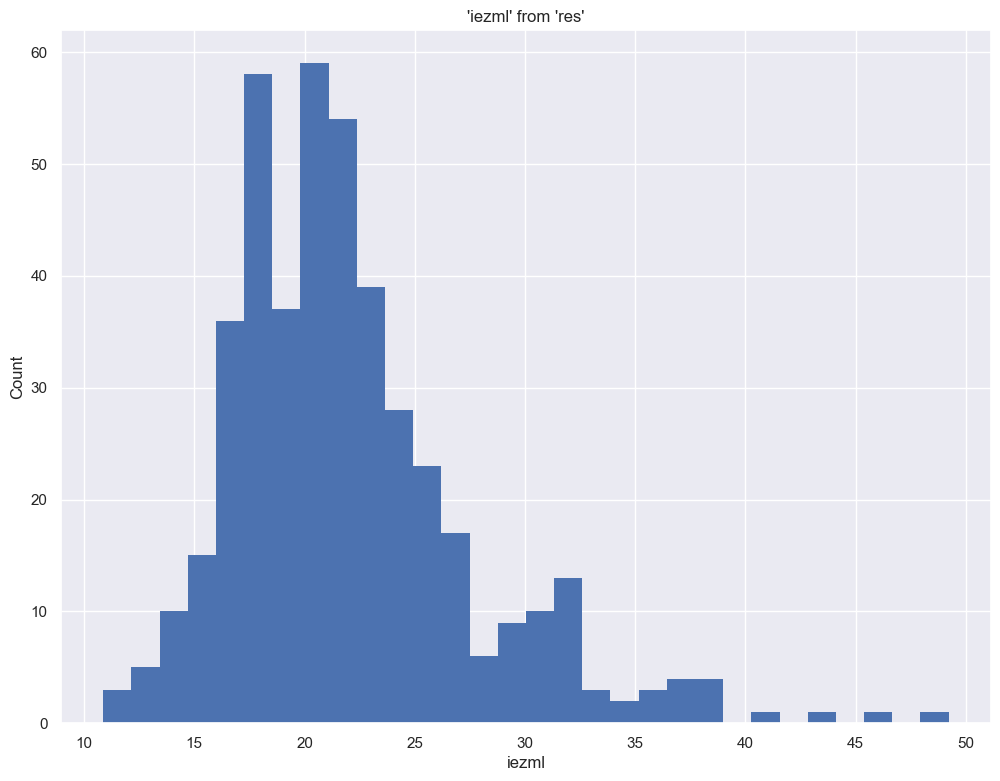

In [52]:
%sqlplot histogram --table res --column iezml --bins 30

<Axes: title={'center': "'avg_res' from 'df'"}, xlabel='avg_res', ylabel='Count'>

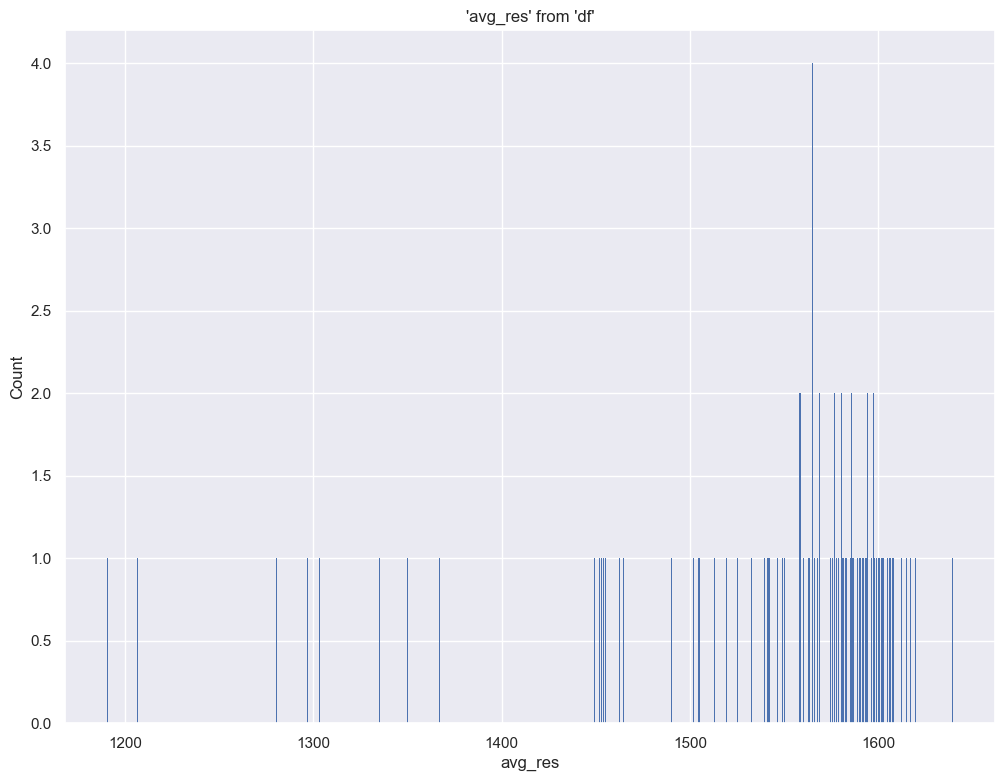

In [53]:
df = conn.execute("""
SELECT
    RegionID,
    SUM(AdvEngineID) as sum,
    COUNT(*) AS c,
    AVG(ResolutionWidth) as avg_res,
    COUNT(DISTINCT UserID) as cduid
FROM tmp_hits
GROUP BY RegionID
ORDER BY c DESC
LIMIT 100
""").df()

%sqlplot histogram --table df --column avg_res --bins 1000

## SQLGlot
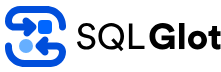

*SQLGlot is a no-dependency SQL parser, transpiler, optimizer, and engine. It can be used to format SQL or translate between 20 different dialects like **DuckDB**, Presto / Trino, Spark / Databricks, Snowflake, and BigQuery. It aims to read a wide variety of SQL inputs and output syntactically and semantically correct SQL in the targeted dialects.* - https://github.com/tobymao/sqlglot

source: https://medium.com/@kayrnt/14-bigquery-shortfalls-that-are-driving-me-crazy-and-how-to-workaround-them-b00b3a1bdf3f

In [54]:
# !pip install sqlglot

In [55]:
import sqlglot
sqlglot.transpile("SELECT EPOCH_MS(1618088028295)", read="duckdb", write="bigquery")[0]

'SELECT UNIX_TO_TIME(1618088028295 / 1000)'

In [56]:
import sqlglot
sqlglot.transpile("SELECT STRFTIME(x, '%y-%-m-%S')", read="duckdb", write="bigquery")[0]

"SELECT TIME_TO_STR(x, '%y-%-m-%S')"

In [57]:
sql = """
    WITH baz AS
        (SELECT a, c FROM foo WHERE a = 1)
    SELECT
        f.a,
        b.b,
        baz.c,
        CAST("b"."a" AS REAL) d
    FROM foo f
    JOIN bar b ON f.a = b.a
    LEFT JOIN baz ON f.a = baz.a"""
print(sqlglot.transpile(sql, read="duckdb", write="bigquery", identify=True, pretty=True)[0])

WITH `baz` AS (
  SELECT
    `a`,
    `c`
  FROM `foo`
  WHERE
    `a` = 1
)
SELECT
  `f`.`a`,
  `b`.`b`,
  `baz`.`c`,
  CAST(`b`.`a` AS FLOAT64) AS `d`
FROM `foo` AS `f`
JOIN `bar` AS `b`
  ON `f`.`a` = `b`.`a`
LEFT JOIN `baz`
  ON `f`.`a` = `baz`.`a`


# DuckDB Blog - https://duckdb.org/news/

## User defined functions

- DuckDB supports vectorized Scalar Python User Defined Functions (UDFs)
- Expand functionality of DuckDB while taking the advantage of DuckDB’s fast execution model, SQL and data safety.

source: https://duckdb.org/2023/07/07/python-udf.html

In [59]:
from duckdb.typing import *


world_cup_titles = {
    "Brazil": 5,
    "Germany": 4,
    "Italy": 4,
    "Argentina": 2,
    "Uruguay": 2,
    "France": 2,
    "England": 1,
    "Spain": 1
}

# Function that will be registered as an UDF, simply does a lookup in the python dictionary
def world_cups(x):
     return world_cup_titles.get(x)

# We register the function
# conn.remove_function("wc_titles") # to re-register function run this
conn.create_function("wc_titles", world_cups, [VARCHAR], INTEGER)

In [61]:
conn.execute("DROP TABLE IF EXISTS countries")
conn.execute("CREATE TABLE countries(country VARCHAR)")
conn.execute("""
    INSERT INTO countries
    VALUES ('Brazil'), ('Germany'), ('Italy'), ('Argentina'), ('Uruguay'), ('France'), ('England'), ('Spain'), ('Netherlands')
""")

# Simply call the function through SQL !
conn.sql("SELECT country, wc_titles(country) as world_cups from countries").df()

country  world_cups
0       Brazil         5.0
1      Germany         4.0
2        Italy         4.0
3    Argentina         2.0
4      Uruguay         2.0
5       France         2.0
6      England         1.0
7        Spain         1.0
8  Netherlands         NaN

In [62]:
# !pip install faker

## Hmm, let's generate some fake data ...

In [63]:
from faker import Faker

def random_date():
     fake = Faker()
     return fake.date_between()

In [65]:
# duckdb.remove_function('random_date') # to re-register function run this
duckdb.create_function('random_date', random_date, [], DATE)

In [66]:
duckdb.sql('select random_date() from range (3)').df() # same output, hmmm ... why?

random_date()
0    1995-10-24
1    1995-10-24
2    1995-10-24

One important thing to notice is that a function that is not deterministic based on its input must be marked as having `side_effects`.

In [67]:
duckdb.remove_function('random_date')
duckdb.create_function('random_date', random_date, [], DATE, side_effects=True)
duckdb.sql('select random_date() from range (3)').df()

random_date()
0    2017-10-07
1    1997-10-14
2    2020-03-30

## How to speed up pandas `apply` by using PyArrow compute

- Let's convert IP address in binary format to a decadical format that follows "xxx.xxx.xxx.xxx" convention

eg. `1207224608` (just raw bits) = `71.244.201.32` (string format)
= **`71244201032`** (int64 format, our target)

In [68]:
small_hits_parquet_df = pd.read_parquet("small_hits.parquet")

In [69]:
# Naive approach

BITS_PER_DOT = 8
LSB_8_MASK = 2**(BITS_PER_DOT) - 1

def ip_to_str_n(x: int) -> int:
    i0 = x & LSB_8_MASK
    x = x >> BITS_PER_DOT
    i1 = x & LSB_8_MASK
    x = x >> BITS_PER_DOT
    i2 = x & LSB_8_MASK
    x = x >> BITS_PER_DOT
    i3 = x & LSB_8_MASK

    return (((((i3 * 1000) + i2) * 1000) + i1) * 1000) + i0
    

In [80]:
from duckdb.typing import *

import pyarrow as pa
import pyarrow.compute as pc

BITS_PER_DOT = 8
LSB_8_MASK = 2**(BITS_PER_DOT) - 1

# Improve ip to 'str' conversion using pyarrow.compute (to speed up)
# Pretty crude solution - but 5x as fast as regular python UDF
def ip_to_str(x):
    i0 = pc.bit_wise_and(x, LSB_8_MASK)
    x = pc.shift_right(x, BITS_PER_DOT)

    i1 = pc.bit_wise_and(x, LSB_8_MASK)
    x = pc.shift_right(x, BITS_PER_DOT)

    i2 = pc.bit_wise_and(x, LSB_8_MASK)
    x = pc.shift_right(x, BITS_PER_DOT)

    i3 = pc.bit_wise_and(x, LSB_8_MASK)
    return pc.add(
                pc.multiply(
                    pc.add(
                        pc.multiply(
                            pc.add(
                                pc.multiply(i3, 1000),
                                i2),
                            1000),
                        i1),
                    1000),
                i0)
                

conn.remove_function('ip_to_str') # uncomment if to redefine function
conn.create_function('ip_to_str', ip_to_str, [BIGINT], BIGINT, type='arrow')

conn.remove_function('ip_to_str_n') # uncomment if to redefine function
conn.create_function('ip_to_str_n', ip_to_str_n, [BIGINT], BIGINT)

In [94]:
import ipaddress

# test
display(ip_to_str_n(1207224608), ipaddress.ip_address(1207224608))

71244201032

IPv4Address('71.244.201.32')

In [95]:
# Directly on dataframe
conn.execute("""
SELECT ClientIP, ip_to_str(ClientIP) as cip
FROM small_hits_parquet_df
""").df()

ClientIP           cip
0        -524741730  224185019158
1        -524741730  224185019158
2        -524741730  224185019158
3        -524741730  224185019158
4        -524741730  224185019158
...             ...           ...
4910527 -1558858532  163021180220
4910528 -1558858532  163021180220
4910529 -1558858532  163021180220
4910530 -1558858532  163021180220
4910531 -1558858532  163021180220

[4910532 rows x 2 columns]

In [96]:
small_hits_parquet_df_pyarrow_tab = pa.Table.from_pandas(small_hits_parquet_df)

In [97]:
# Directly on pyarrow table
conn.execute("""
SELECT ClientIP, ip_to_str(ClientIP) as cip
FROM small_hits_parquet_df_pyarrow_tab
""").df()

ClientIP           cip
0        -524741730  224185019158
1        -524741730  224185019158
2        -524741730  224185019158
3        -524741730  224185019158
4        -524741730  224185019158
...             ...           ...
4910527 -1558858532  163021180220
4910528 -1558858532  163021180220
4910529 -1558858532  163021180220
4910530 -1558858532  163021180220
4910531 -1558858532  163021180220

[4910532 rows x 2 columns]

In [98]:
# On parquet data
conn.execute("""
SELECT ClientIP, ip_to_str(ClientIP) as cip
FROM small_hits.parquet
""").df()

ClientIP           cip
0        -524741730  224185019158
1        -524741730  224185019158
2        -524741730  224185019158
3        -524741730  224185019158
4        -524741730  224185019158
...             ...           ...
4910527 -1558858532  163021180220
4910528 -1558858532  163021180220
4910529 -1558858532  163021180220
4910530 -1558858532  163021180220
4910531 -1558858532  163021180220

[4910532 rows x 2 columns]

In [99]:
# Naive
conn.execute("""
SELECT ClientIP, ip_to_str_n(ClientIP) as cip
FROM small_hits_parquet_df
""").df()

ClientIP           cip
0        -524741730  224185019158
1        -524741730  224185019158
2        -524741730  224185019158
3        -524741730  224185019158
4        -524741730  224185019158
...             ...           ...
4910527 -1558858532  163021180220
4910528 -1558858532  163021180220
4910529 -1558858532  163021180220
4910530 -1558858532  163021180220
4910531 -1558858532  163021180220

[4910532 rows x 2 columns]

In [100]:
# Pandas
small_hits_parquet_df['ClientIP'].apply(ip_to_str_n)

0          224185019158
1          224185019158
2          224185019158
3          224185019158
4          224185019158
               ...     
4910527    163021180220
4910528    163021180220
4910529    163021180220
4910530    163021180220
4910531    163021180220
Name: ClientIP, Length: 4910532, dtype: int64

## Reading JSON Automatically with DuckDB
source: https://duckdb.org/2023/03/03/json.html

In [102]:
json_str = '''
[
  {
    "userId": 1,
    "id": 1,
    "title": "Go to school",
    "completed": 1
  },
  {
    "userId": 1,
    "id": 2,
    "title": "Watch a movie",
    "completed": 0
  },
  {
    "userId": 1,
    "id": 3,
    "title": "Code some Python",
    "completed": 1
  },
  {
    "userId": 1,
    "id": 4,
    "title": "Go to Pycon",
    "completed": 1
  },
  {
    "userId": 1,
    "id": 5,
    "title": "Code some Python",
    "completed": 0
  },
  {
    "userId": 1,
    "id": 6,
    "title": "Watch a movie",
    "completed": 0
  },
  {
    "userId": 1,
    "id": 7,
    "title": "Code some Python",
    "completed": 1
  }
]
'''
json_file = open("nested.json", "w")
json_file.write(json_str)
json_file.close()
!ls -lah | grep -w "nested.json"

-rw-r--r--@  1 gkaretka  staff   626B Nov 30 11:18 nested.json


In [103]:
df = conn.execute("SELECT * FROM 'nested.json'").df()
df

userId  id             title  completed
0       1   1      Go to school          1
1       1   2     Watch a movie          0
2       1   3  Code some Python          1
3       1   4       Go to Pycon          1
4       1   5  Code some Python          0
5       1   6     Watch a movie          0
6       1   7  Code some Python          1

<Axes: title={'center': "'completed' from 'df'"}, xlabel='completed', ylabel='Count'>

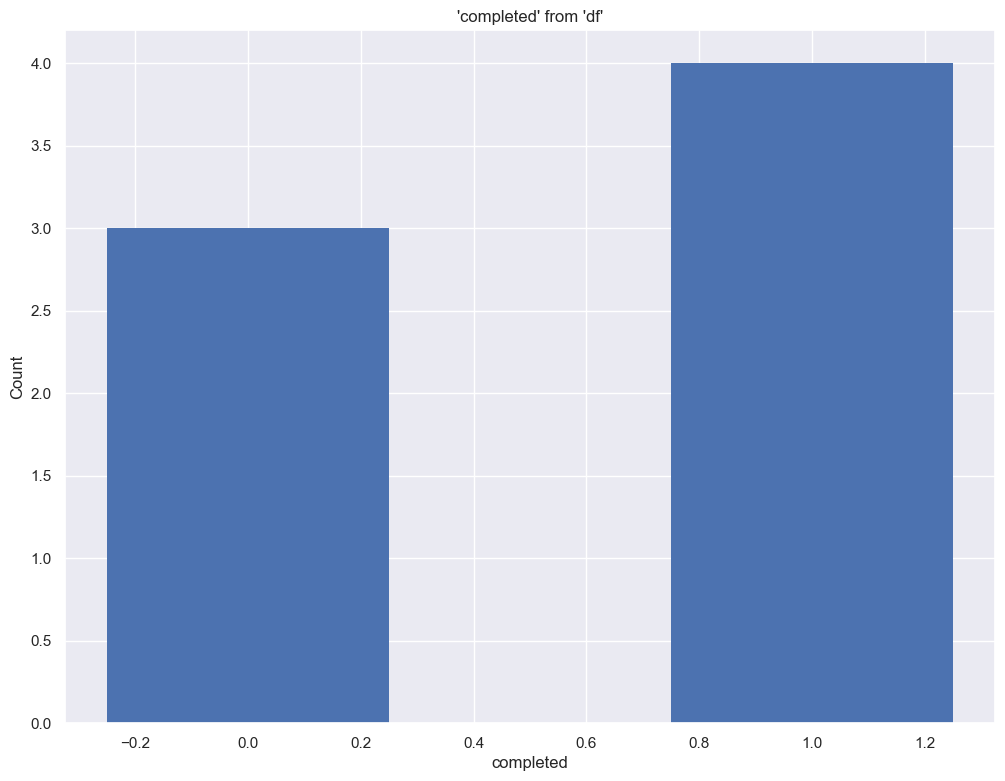

In [104]:
%sqlplot histogram --table df --column completed --bins 3

In [105]:
conn.execute("SELECT * FROM 'nested.json' WHERE completed = True").df()

userId  id             title  completed
0       1   1      Go to school          1
1       1   3  Code some Python          1
2       1   4       Go to Pycon          1
3       1   7  Code some Python          1

In [106]:
conn.execute("SELECT * FROM 'nested.json' WHERE completed = 0").df()

userId  id             title  completed
0       1   2     Watch a movie          0
1       1   5  Code some Python          0
2       1   6     Watch a movie          0

## DuckDB quacks Arrow: A zero-copy data integration between Apache Arrow and DuckDB

- Larger Than Memory Analysis
- Complex Data Types (lists, maps, ...)
- Advanced Optimizer - push down filters and projections (partition elimination Parquet files)

source: https://duckdb.org/2021/12/03/duck-arrow.html

In [107]:
!curl -L https://github.com/duckdb/duckdb-web/blob/main/_posts/data/integers.parquet --url-query raw=true -o integers.parquet
!curl -L https://github.com/cwida/duckdb-data/releases/download/v1.0/lineitemsf1.snappy.parquet -o lineitemsf1.snappy.parquet
!ls -lah | grep integers
!ls -lah | grep lineitemsf1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   543  100   543    0     0    544      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  196M  100  196M    0     0  9513k      0  0:00:21  0:00:21 --:--:-- 25.3M
-rw-r--r--@  1 gkaretka  staff   543B Nov 30 11:19 integers.parquet
-rw-r--r--@  1 gkaretka  staff   197M Nov 30 11:19 lineitemsf1.snappy.parquet


### Querying through realtionship API

In [108]:
import duckdb
import pyarrow as pa
from pyarrow import parquet as pq
import pyarrow.dataset as ds

# Reads Parquet File to an Arrow Table
arrow_table = pq.read_table('integers.parquet')

In [109]:
# Transforms Arrow Table -> DuckDB Relation
rel_from_arrow = duckdb.arrow(arrow_table)

In [110]:
# we can run a SQL query on this and print the result
rel_from_arrow.query('arrow_table', 'SELECT SUM(data) FROM arrow_table WHERE data > 50').df()

sum("data")
0       1100.0

In [111]:
# Transforms DuckDB Relation -> Arrow Table
arrow_table_from_duckdb = rel_from_arrow.arrow()

### Using replacement scans and querying the object directly with SQL

In [112]:
# Reads Parquet File to an Arrow Table
arrow_table = pq.read_table('integers.parquet')

In [113]:
# we can run a SQL query on this and print the result
print(conn.execute('SELECT SUM(data) FROM arrow_table WHERE data > 50').fetchone())

(1100,)


In [114]:
# Transforms Query Result from DuckDB to Arrow Table
# We can directly read the arrow object through DuckDB's replacement scans.
arrow_table_all = conn.execute("SELECT * FROM arrow_table").fetch_arrow_table()

In [115]:
"""
def equals(self, ChunkedArray other):
    '''
    Return whether the contents of two chunked arrays are equal.

    Parameters
    ----------
    other : pyarrow.ChunkedArray
        Chunked array to compare against.

    Returns
    -------
    are_equal : bool
    ...
"""

display(arrow_table_from_duckdb == arrow_table_all)

True

## Projection pushdown

In [116]:
lineitem = pq.read_table('lineitemsf1.snappy.parquet')

# Transforms Query Result from DuckDB to Arrow Table
res_df = conn.execute("""SELECT
                sum(l_extendedprice * l_discount) AS sum
                FROM lineitem;""").df()

In [117]:
# Pandas
arrow_table = pq.read_table('lineitemsf1.snappy.parquet')

# Converts an Arrow table to a Dataframe
df = arrow_table.to_pandas()

# Runs aggregation
res =  pd.DataFrame({'sum': [(df.l_extendedprice * df.l_discount).sum()]})

In [118]:
display(res_df['sum'], res_df['sum'])

0    1.147509e+10
Name: sum, dtype: float64

0    1.147509e+10
Name: sum, dtype: float64

## Filter Pushdown

In [119]:
res_df = conn.execute("""SELECT sum(l_extendedprice * l_discount) AS revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1994-01-01' AS date)
            AND l_shipdate < CAST('1995-01-01' AS date)
            AND l_discount BETWEEN 0.05
            AND 0.07
            AND l_quantity < 24; """).df()

In [120]:
arrow_table = pq.read_table('lineitemsf1.snappy.parquet')

df = arrow_table.to_pandas()
filtered_df = df[
        (df.l_shipdate >= "1994-01-01") &
        (df.l_shipdate < "1995-01-01") &
        (df.l_discount >= 0.05) &
        (df.l_discount <= 0.07) &
        (df.l_quantity < 24)]

res =  pd.DataFrame({'sum': [(filtered_df.l_extendedprice * filtered_df.l_discount).sum()]})

In [121]:
display(res_df, res)

revenue
0  1.231411e+08

sum
0  1.231411e+08

# Datalake and stuff


*A data lake is a centralized repository designed to store, process, and secure large amounts of structured, semistructured, and unstructured data.*

    - Google Cloud Website

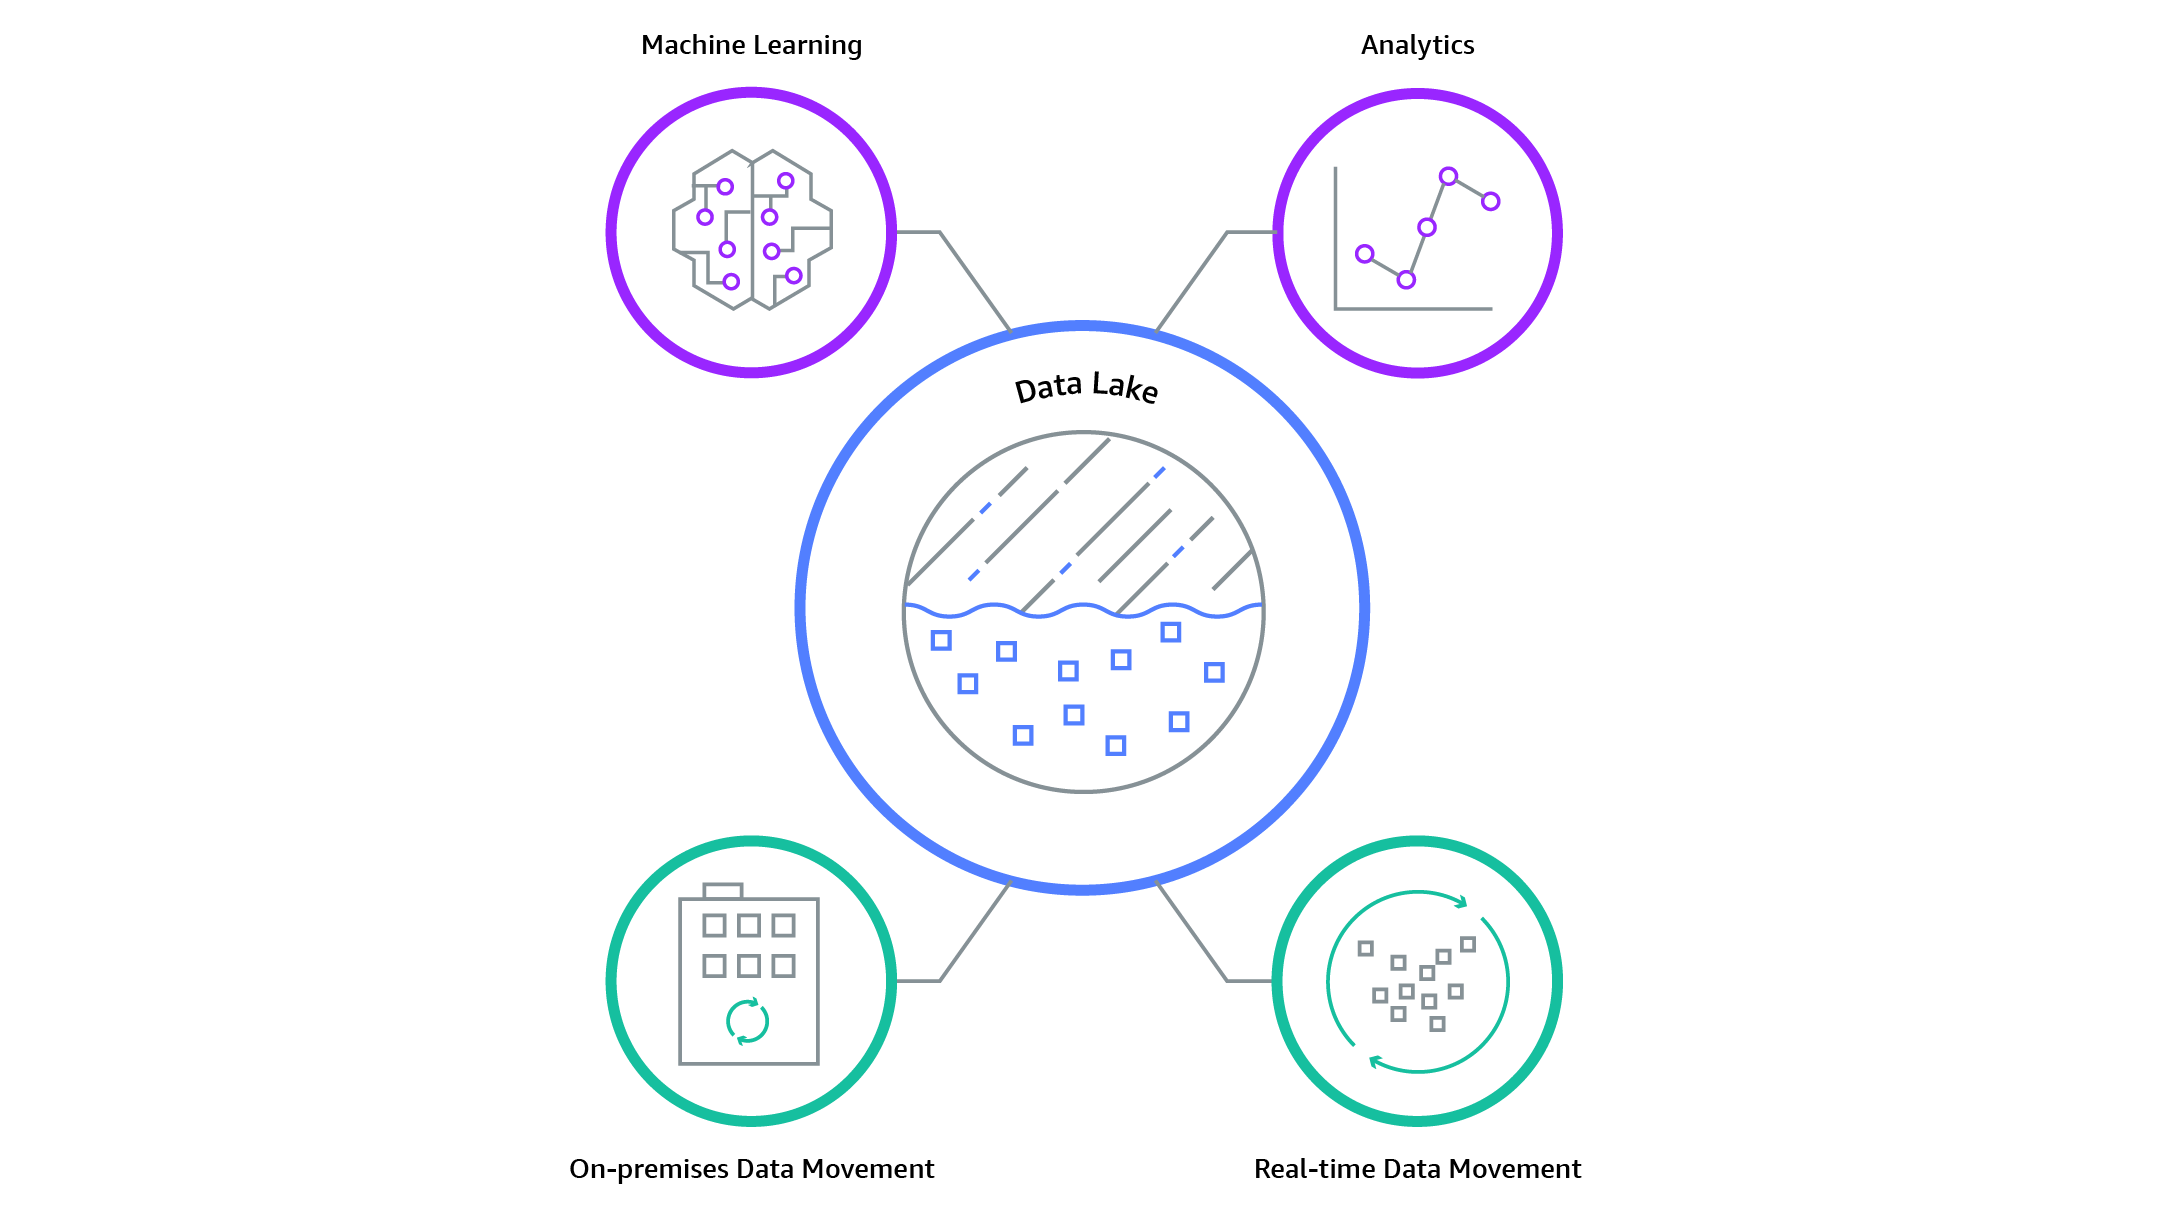

source: https://cmcglobal.com.vn/digtal-transformation/data-analytics-ai/what-are-data-lakes/


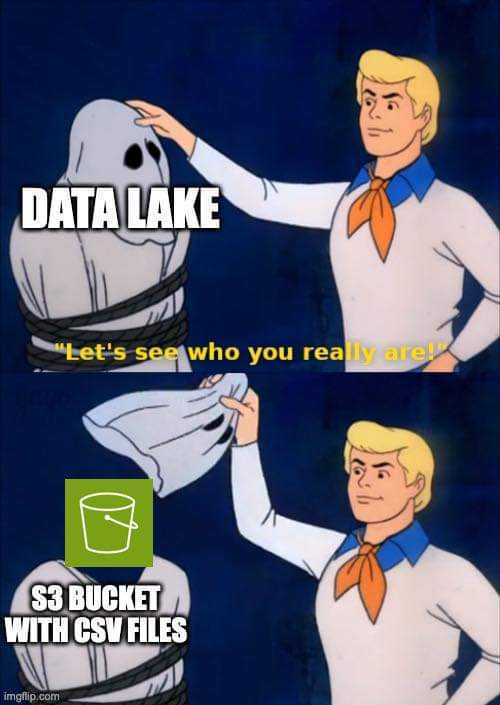

## Apache Iceberg

*Iceberg is a high-performance format for huge analytic tables. Iceberg brings the reliability and simplicity of SQL tables to big data, while making it possible for engines like Spark, Trino, Flink, Presto, Hive and Impala to safely work with the same tables, at the same time.* - Apache Iceberg

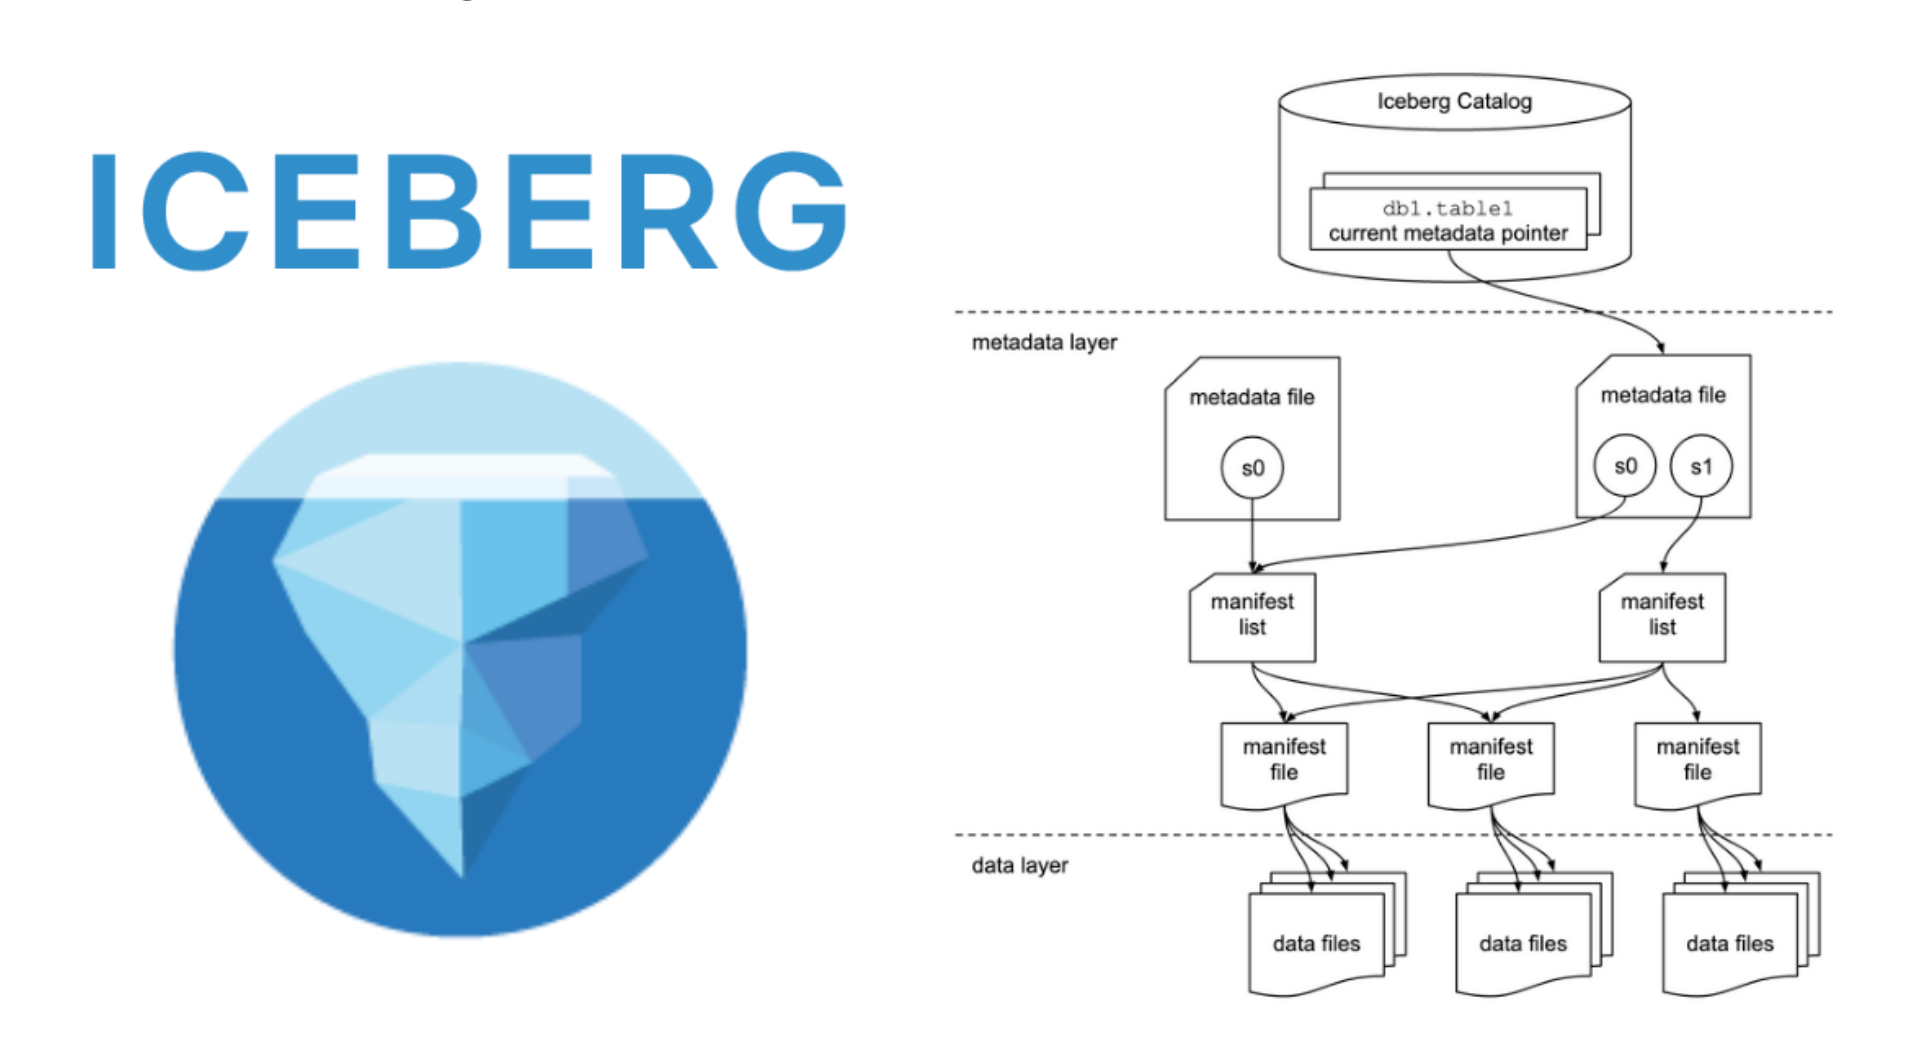

## but Apache is mostly Java, right ?

Not really anymore: PyIceberg is a Python implementation for accessing Iceberg tables, without the need of a JVM.

```
pip install "pyiceberg[duckdb,pandas,pyarrow,glue]"
```

## How to query large amounts of data easily
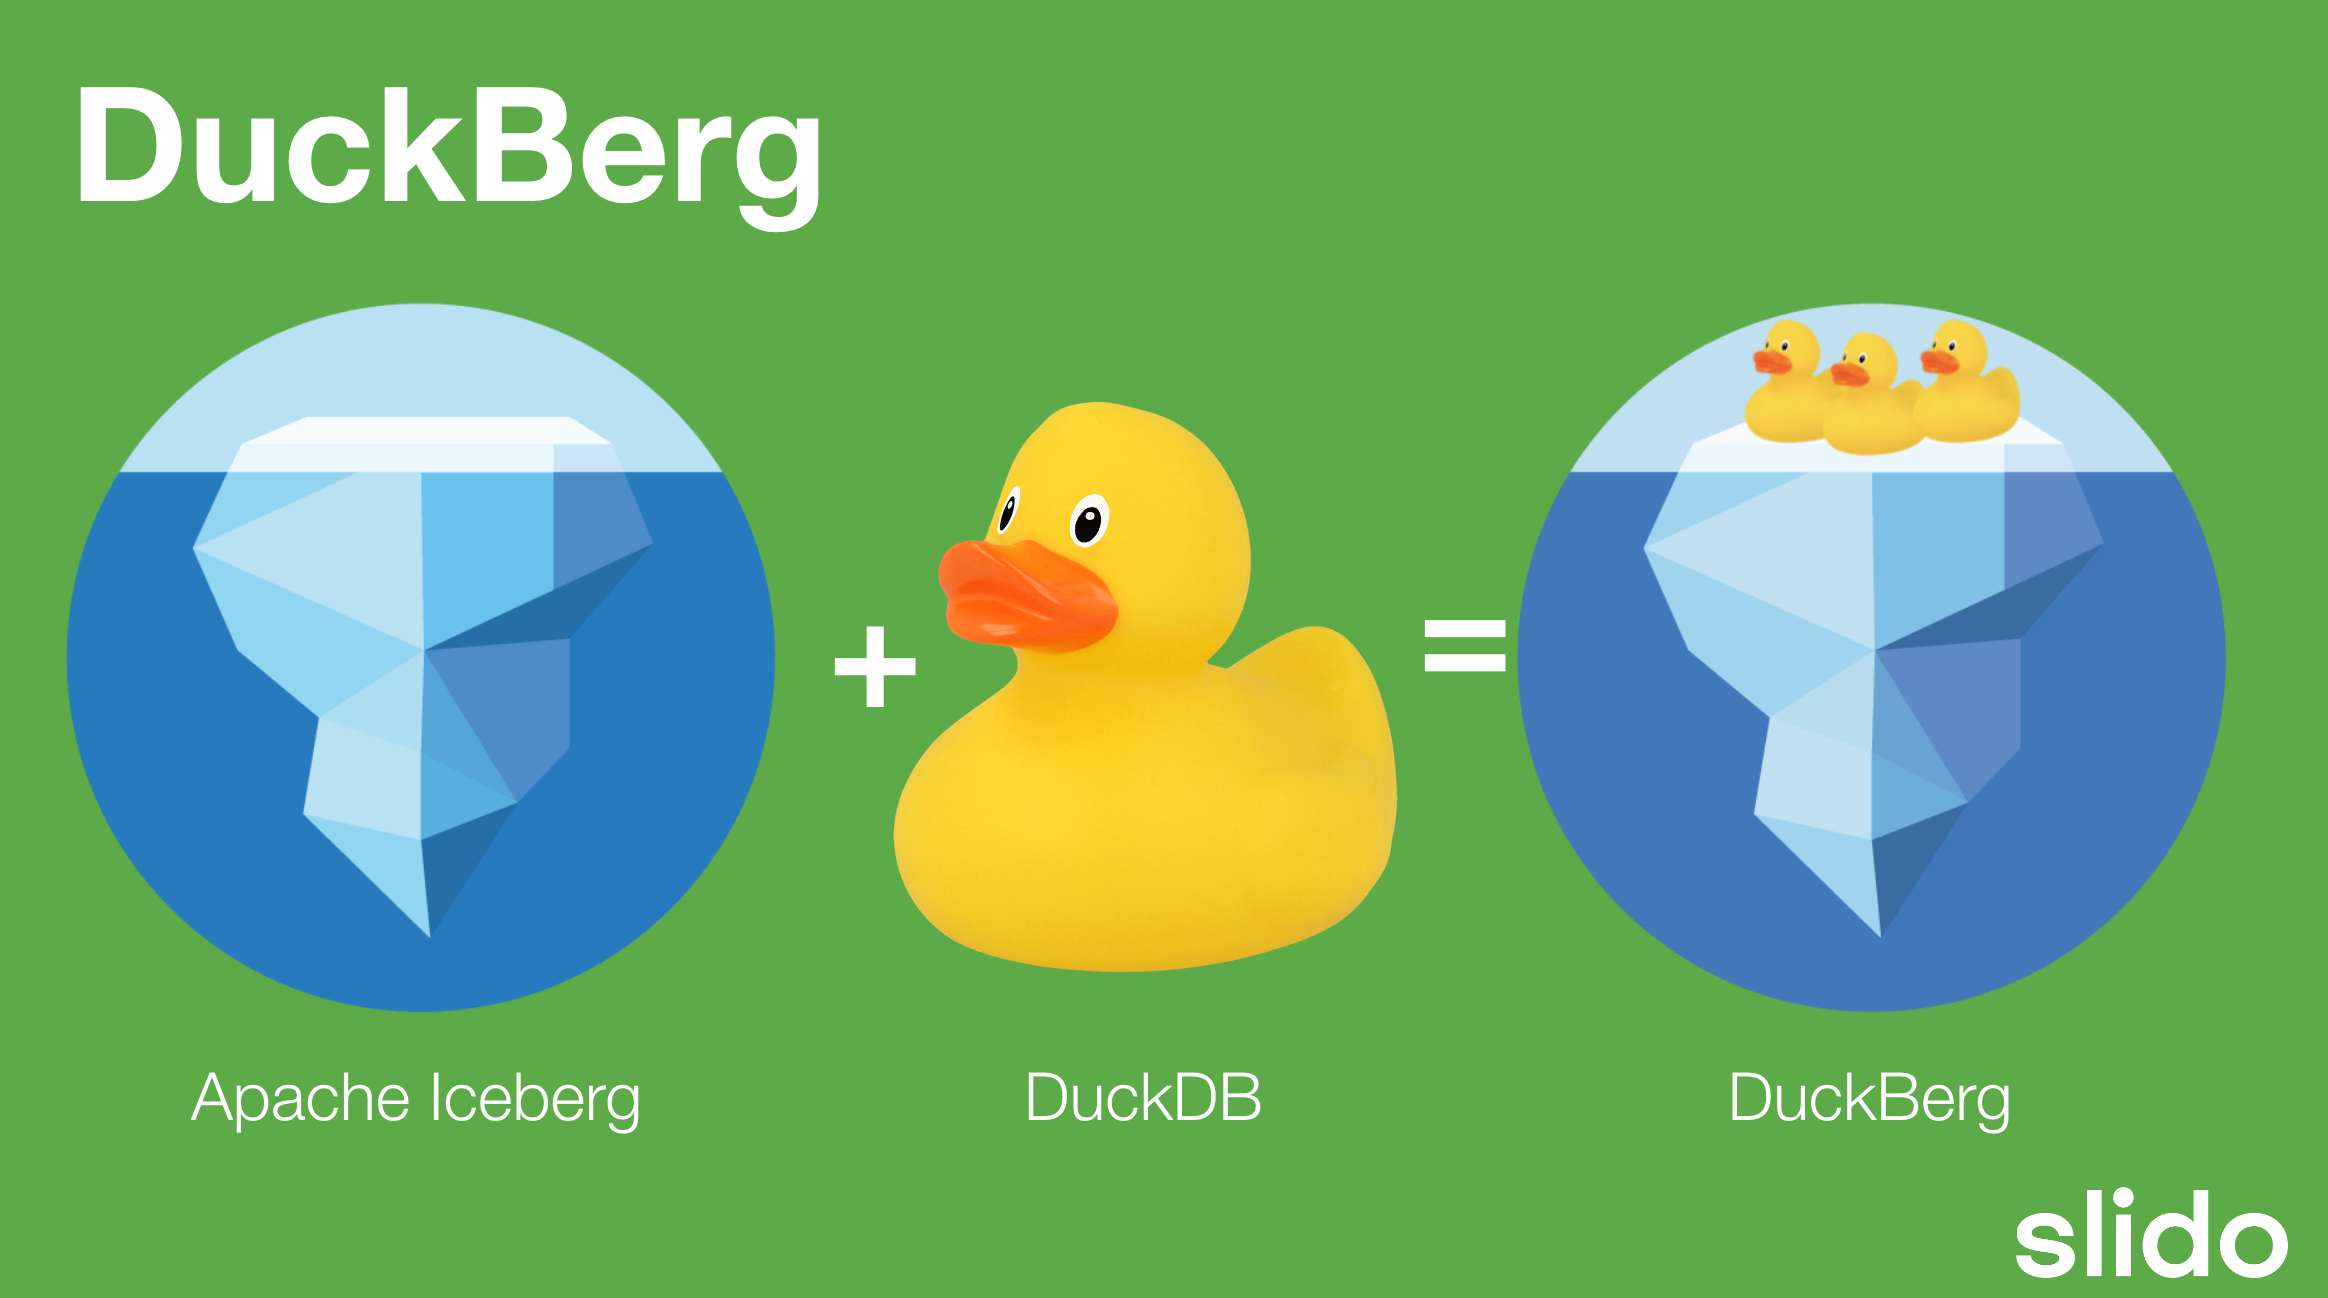

## https://github.com/slidoapp/duckberg

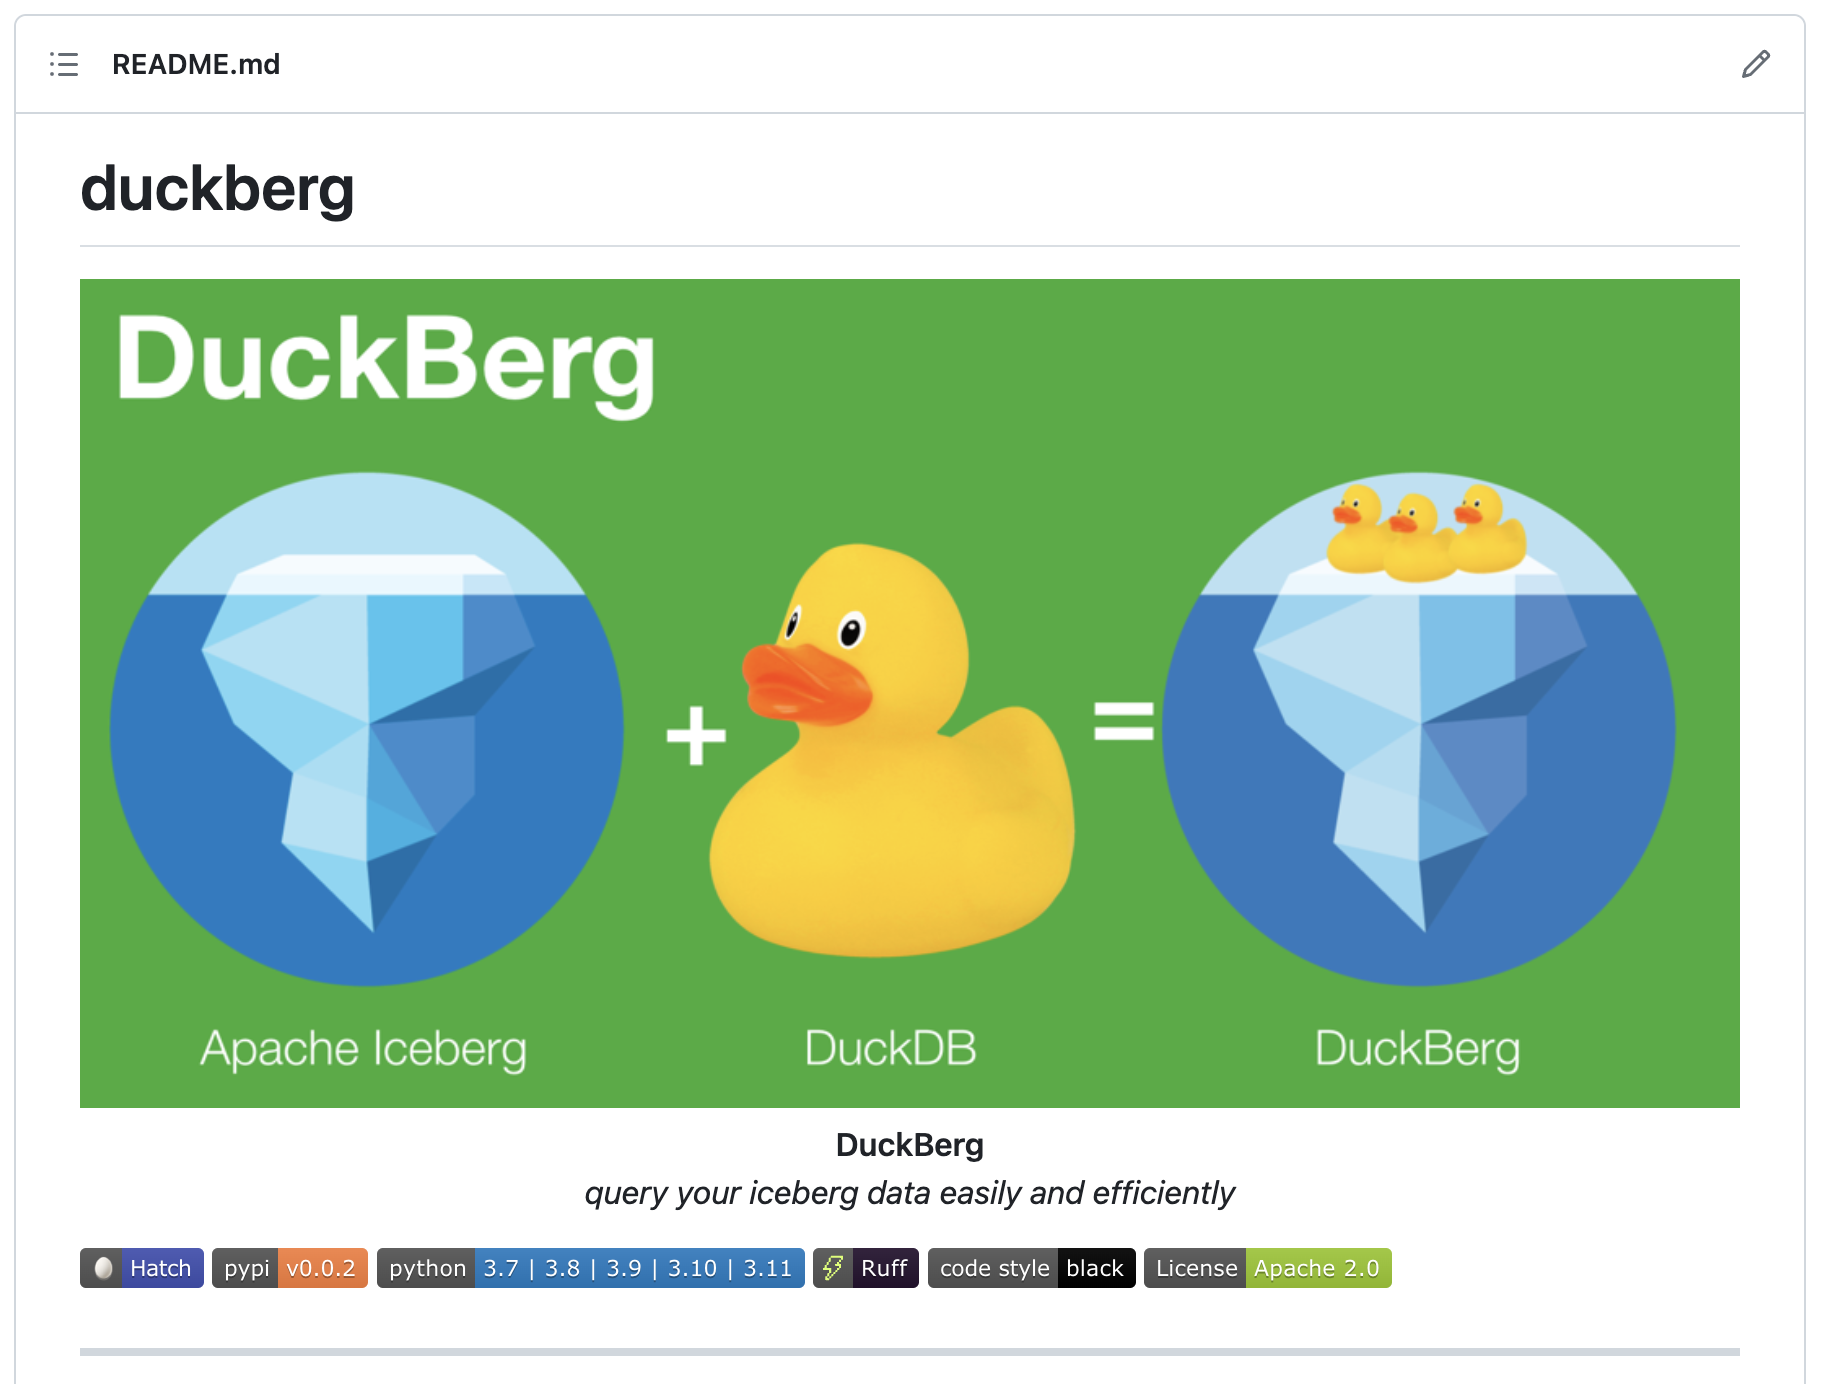

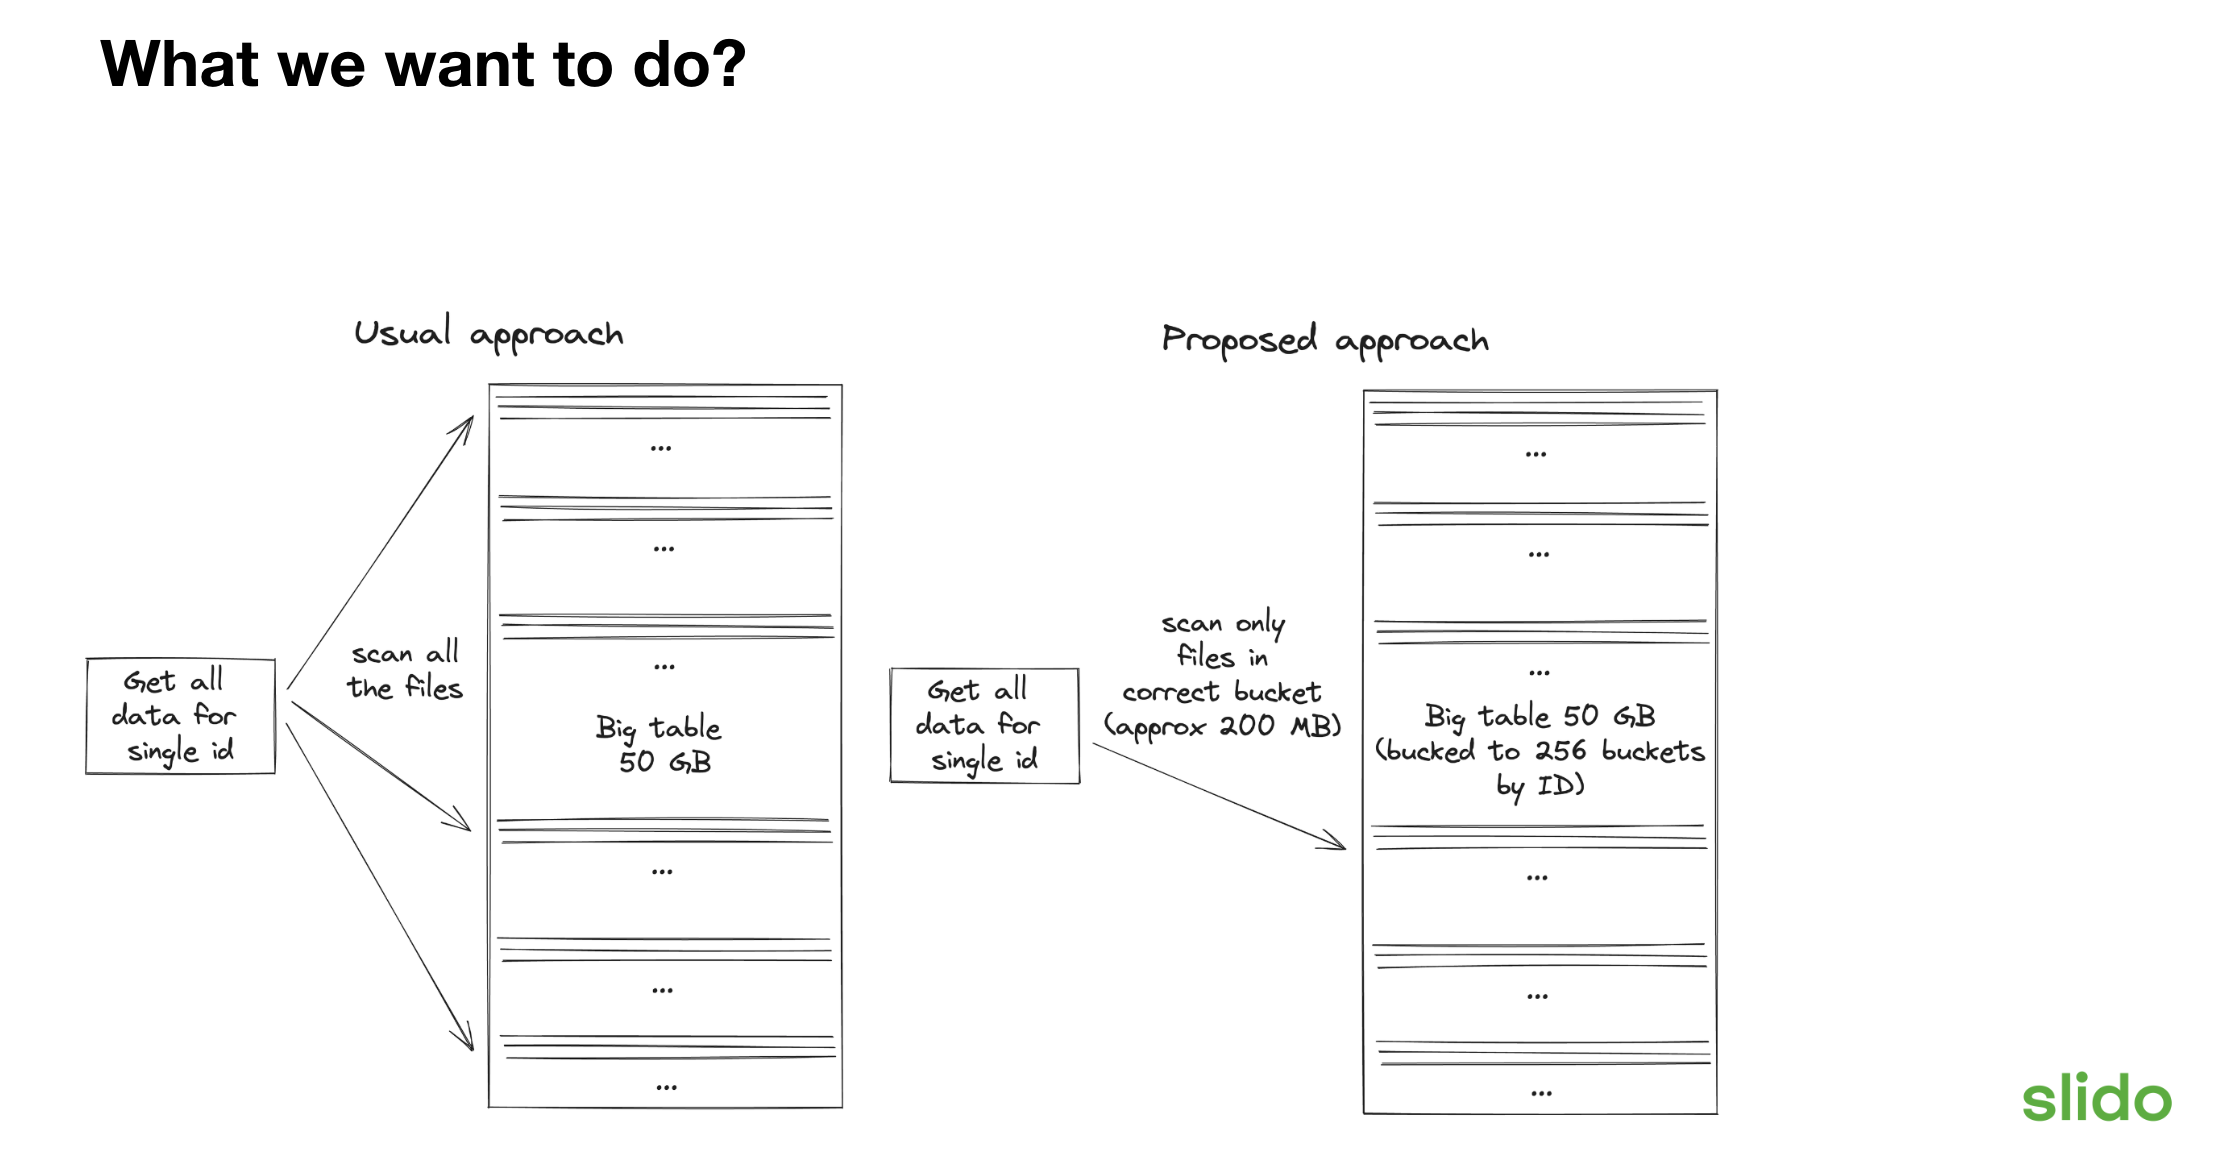
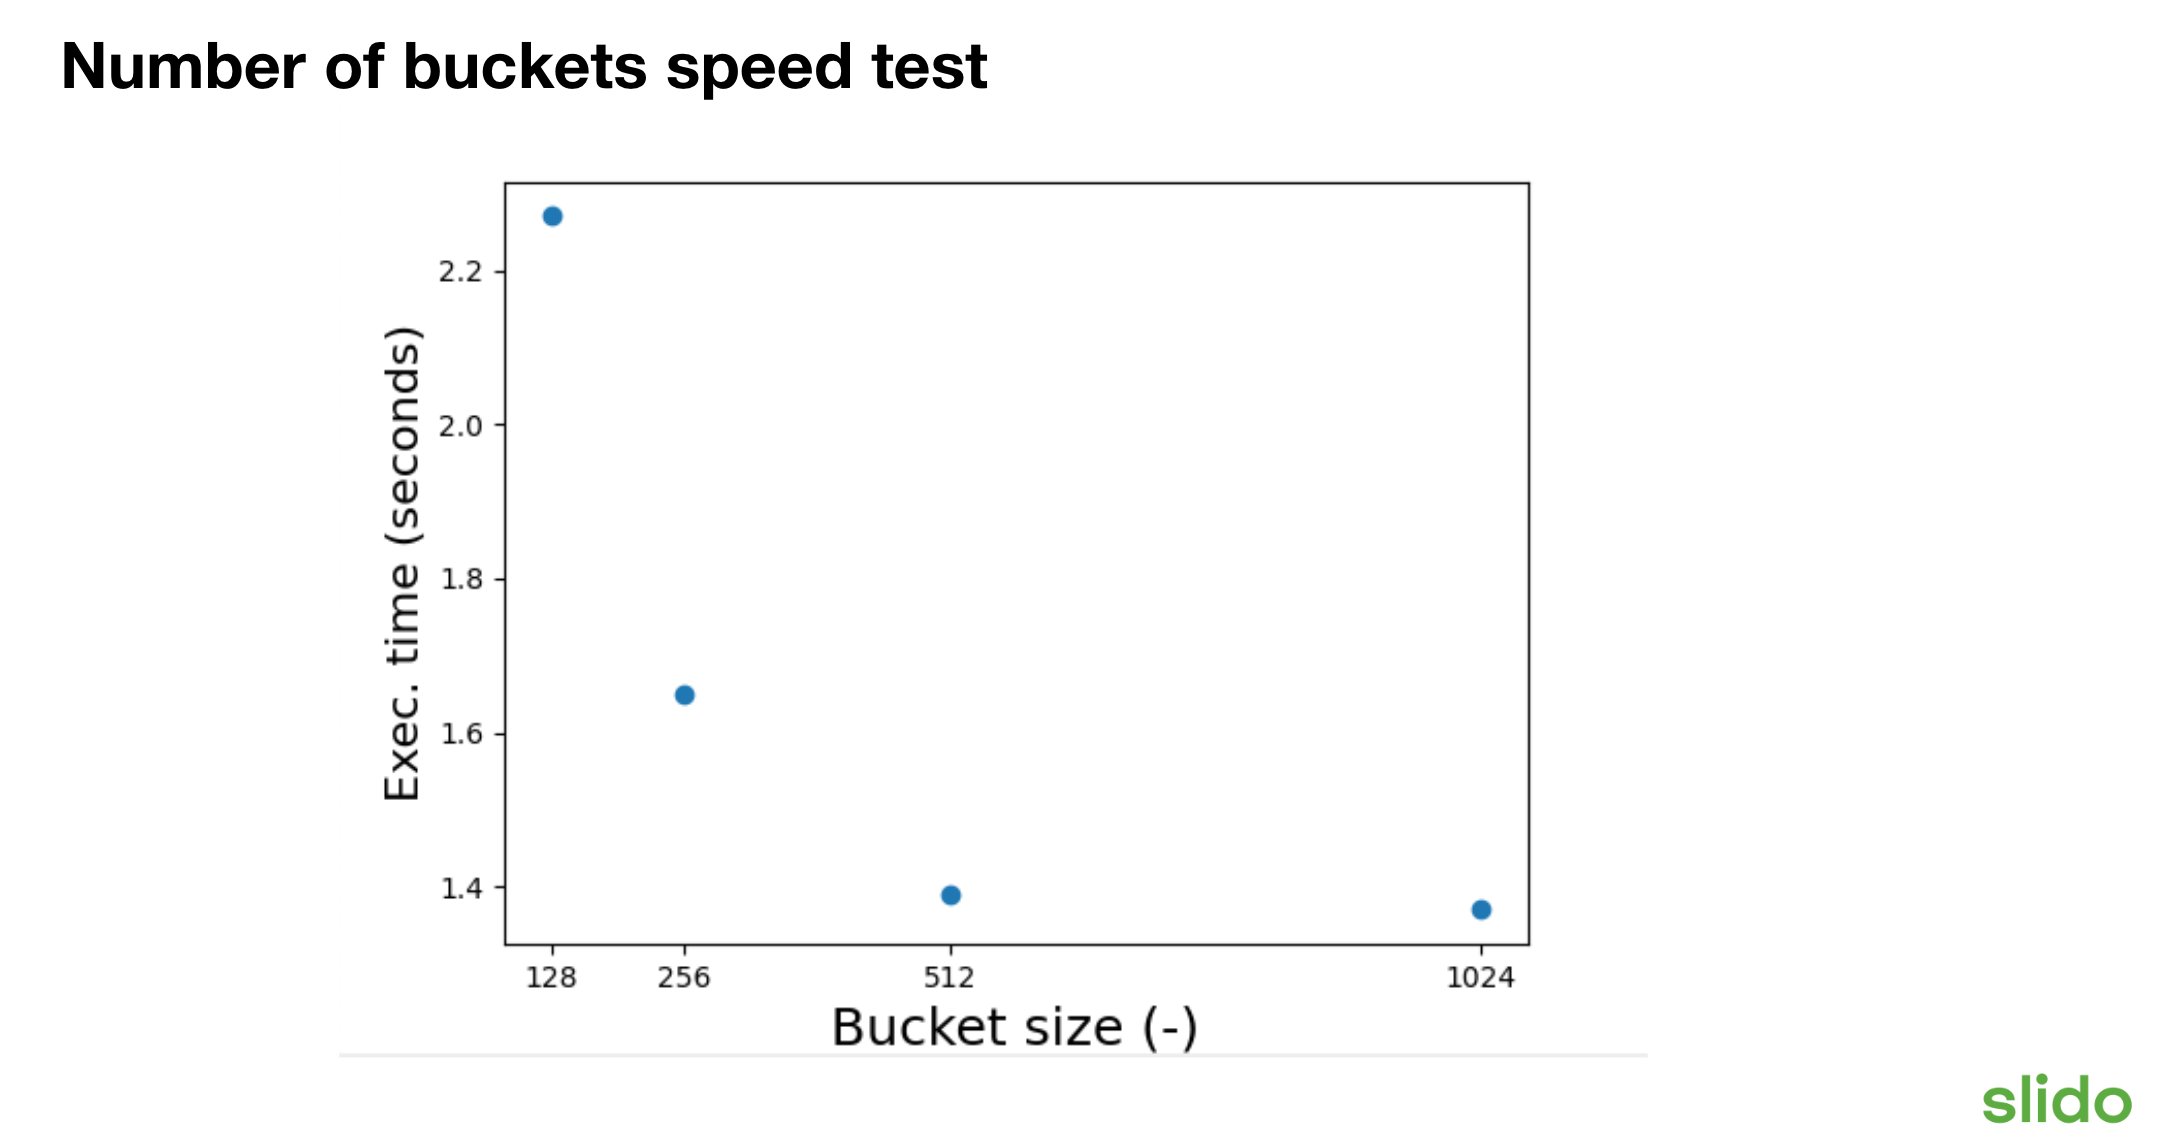

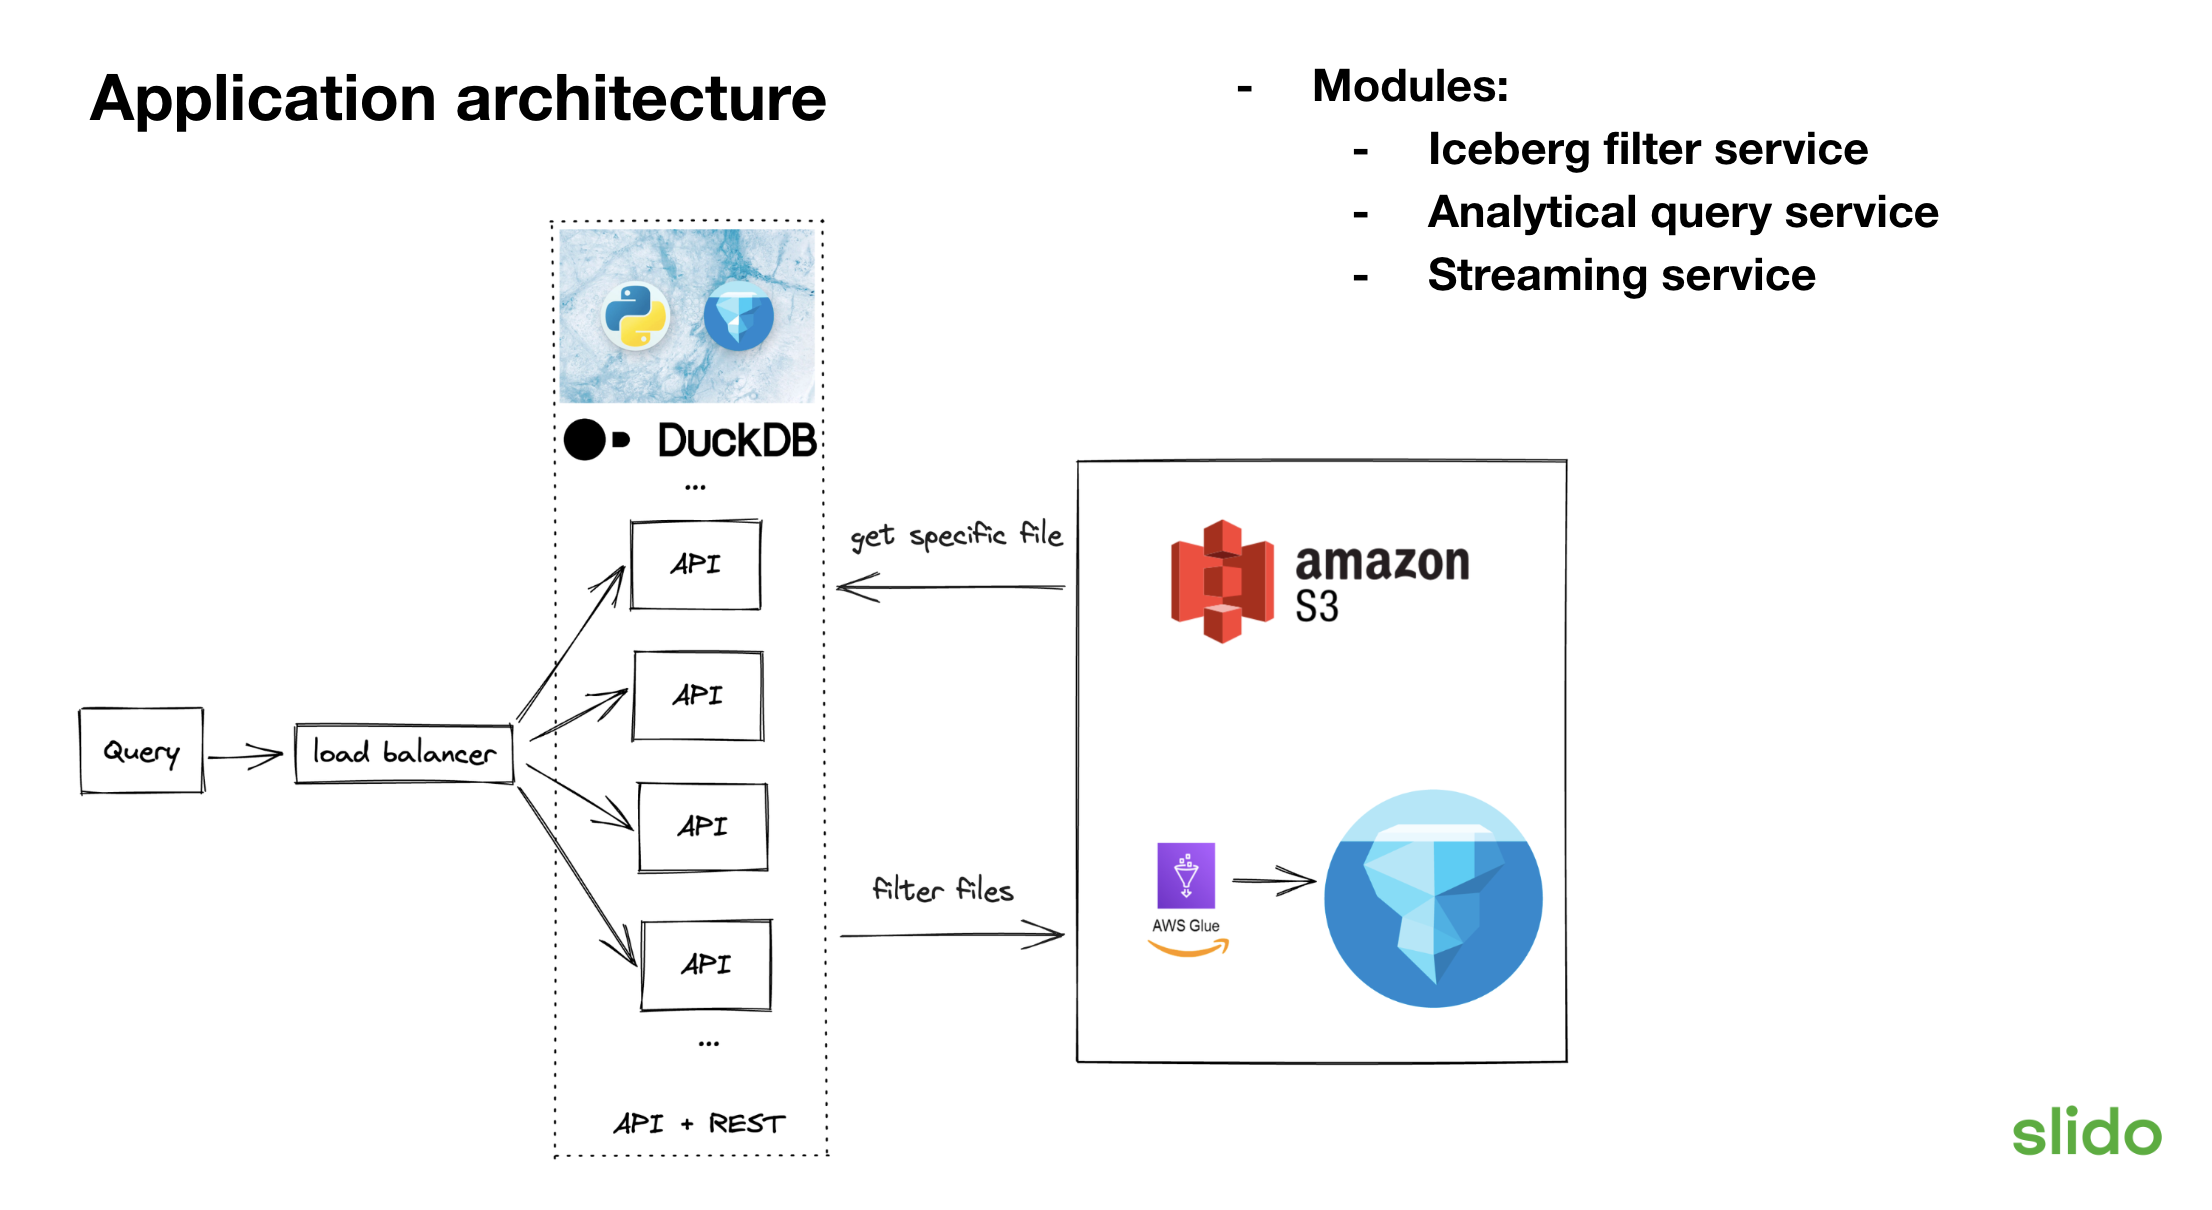

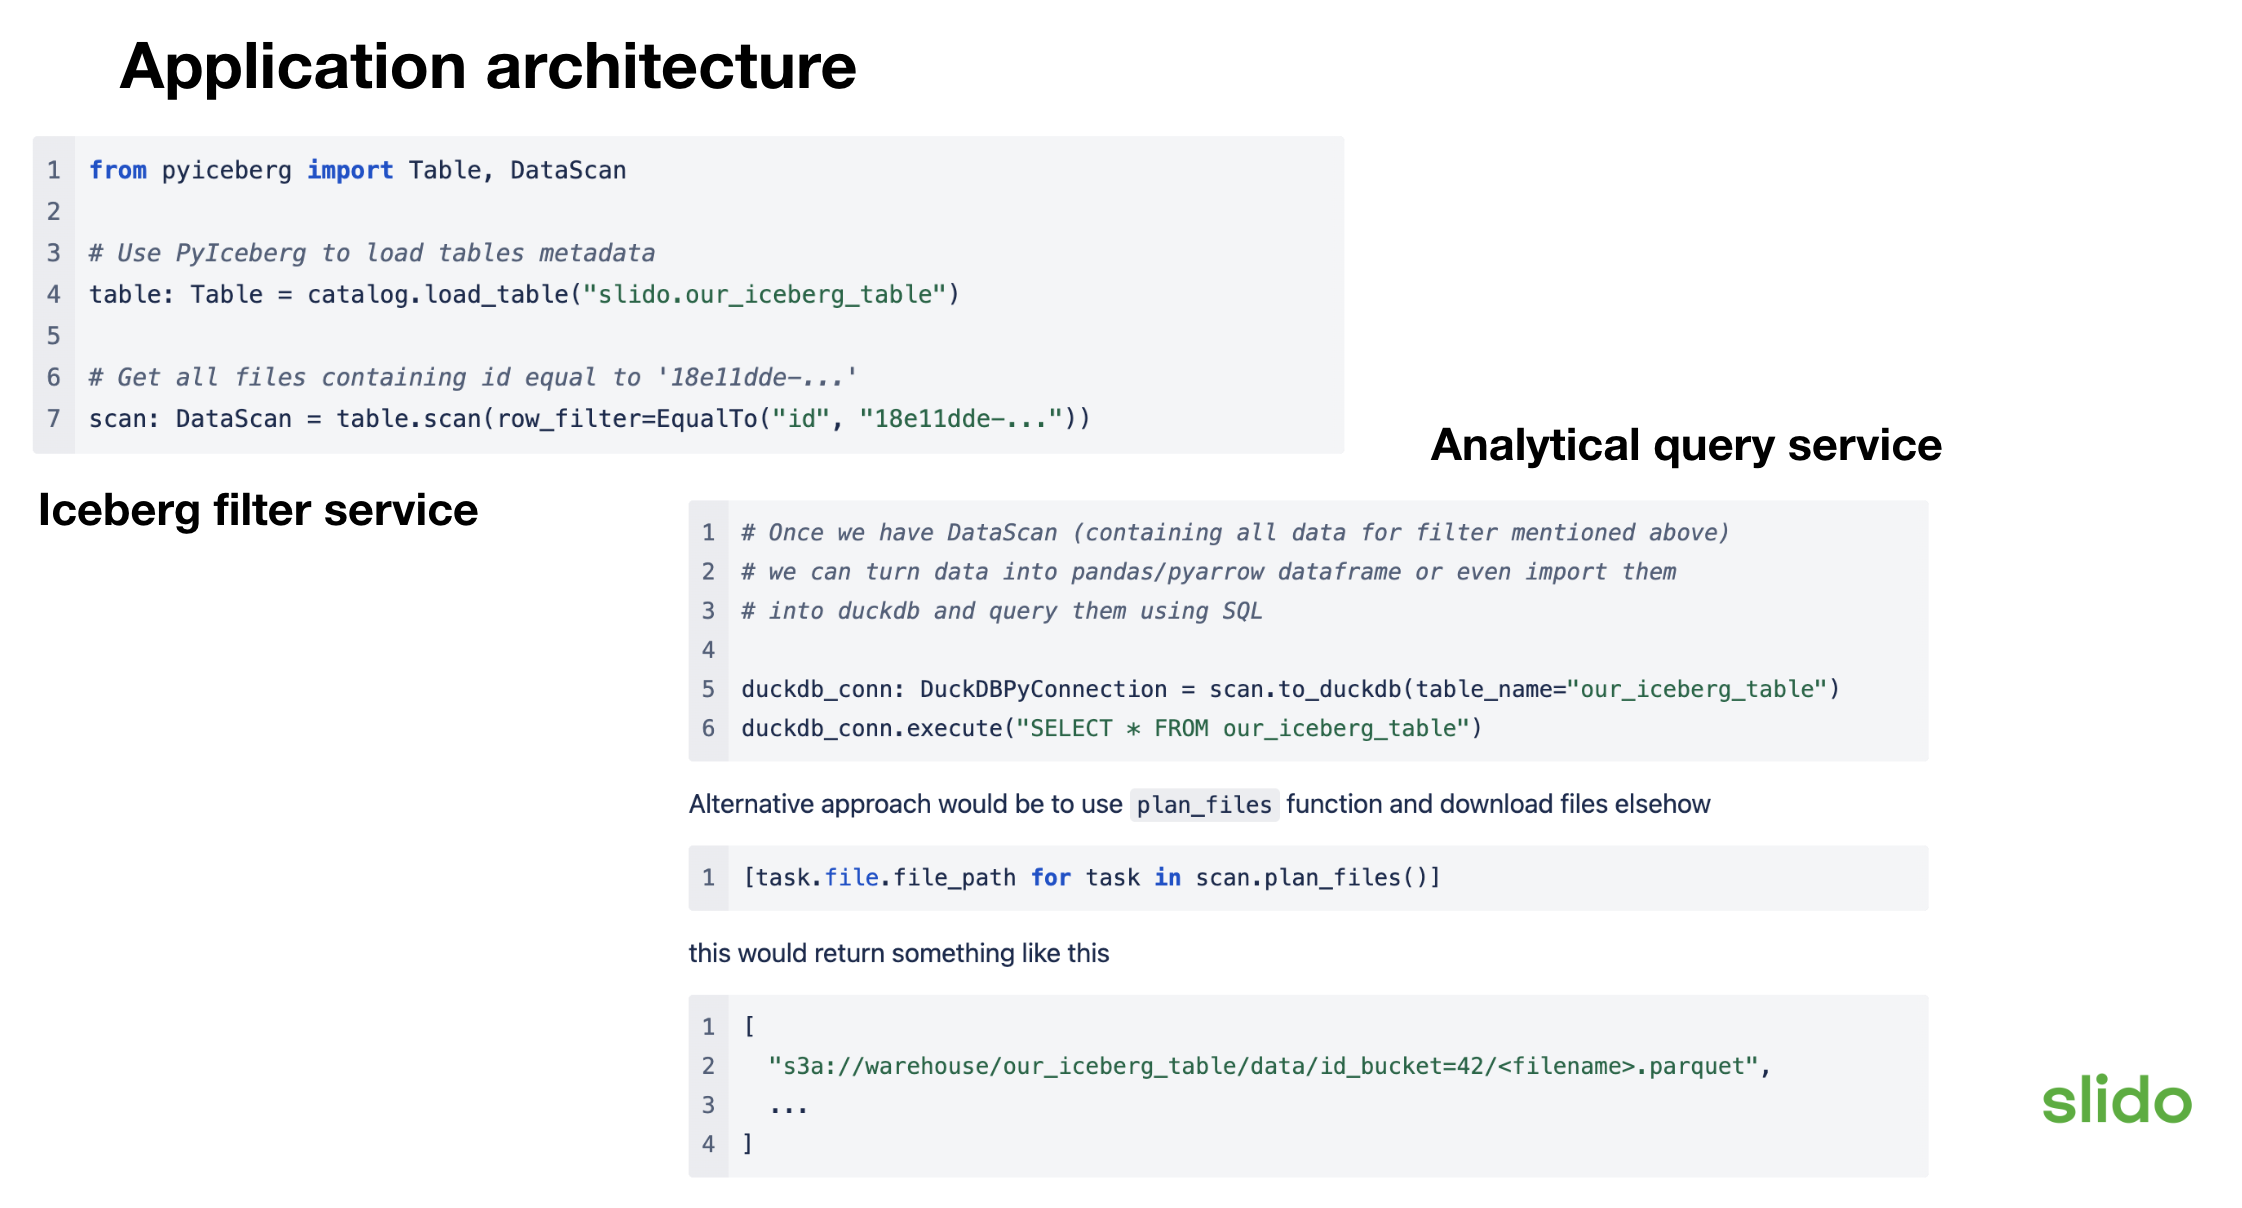

## Duckberg

*Combination of Apache Iceberg's pyiceberg and duckdb to perform fast queries on iceberg data.* - Slido DuckBerg team

1. Git clone (do not clone to the same folder where is this notebook): https://github.com/slidoapp/duckberg/ 
2. Go to: https://github.com/slidoapp/duckberg/tree/main/playground and **start docker + execute init notebook**
3. Go to: http://localhost:8889/ and run everything in `000 Init Iceberg data.ipynb` to setup data
5. Done, you are ready to rock!

In [123]:
# !pip install duckberg

In [124]:
from duckberg import DuckBerg

MINIO_URI = "http://localhost:9000/"
MINIO_USER = "admin"
MINIO_PASSWORD = "password"

catalog_config: dict[str, str] = {
  "type": "rest",
  "uri": "http://localhost:8181/",
  "credentials": "admin:password",
  "s3.endpoint": MINIO_URI,
  "s3.access-key-id": MINIO_USER,
  "s3.secret-access-key": MINIO_PASSWORD
}

In [125]:
db = DuckBerg(
     catalog_name="warehouse",
     catalog_config=catalog_config)

Perform select from table in catalog and do some basic filtering. Iceberg filtering is done
using pyiceberg, SQL filtering is done using DuckDB.

In [126]:
tables = db.list_tables()
tables

['nyc.taxis']

In [127]:
partitions = db.list_partitions(table="nyc.taxis")
partitions

['payment_type']

In [129]:
query = "SELECT * FROM 'nyc.taxis' WHERE trip_distance > 40 ORDER BY tolls_amount DESC"
df = db.select(table="nyc.taxis", partition_filter="payment_type = 1", sql=query)
df.head(10)

VendorID      tpep_pickup_datetime     tpep_dropoff_datetime  \
0         2 2022-03-02 08:18:59+01:00 2022-03-02 10:21:20+01:00   
1         2 2022-03-28 19:56:09+02:00 2022-03-28 22:26:28+02:00   
2         2 2022-01-05 01:40:02+01:00 2022-01-05 03:28:48+01:00   
3         1 2022-03-15 02:37:35+01:00 2022-03-15 04:37:34+01:00   
4         2 2022-02-18 18:30:59+01:00 2022-02-18 21:27:41+01:00   
5         2 2022-02-27 17:38:02+01:00 2022-02-27 18:47:05+01:00   
6         1 2022-01-06 19:33:09+01:00 2022-01-06 21:51:46+01:00   
7         2 2022-02-06 17:36:38+01:00 2022-02-06 19:30:41+01:00   
8         2 2022-03-11 15:34:16+01:00 2022-03-11 17:20:04+01:00   
9         2 2022-03-31 08:56:08+02:00 2022-03-31 10:34:13+02:00   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0              1.0          80.17         5.0                  N   
1              1.0         151.16         4.0                  N   
2              4.0          84.18         5.0                  N   
3              1.0          78.20         5.0                  N   
4              1.0          61.20         3.0                  N   
5              1.0          67.88         4.0                  N   
6              1.0         139.80         5.0                  N   
7              1.0          86.50         5.0                  N   
8              3.0          84.33         5.0                  N   
9              1.0          62.26         5.0                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           132           265             1        250.0   0.00      0.0   
1           132           265             1        540.5   1.00      0.5   
2           132           265             1        400.0   0.00      0.0   
3           132           265             1        200.0   1.25      0.0   
4           138           138             1        203.0   1.00      0.0   
5           132           265             1        128.0   0.00      0.5   
6           132           265             1        375.0   0.00      0.0   
7           132           265             1        425.0   0.00      0.0   
8            90           265             1        332.5   0.00      0.0   
9           132           265             1        310.0   0.00      0.0   

   tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0        0.10         54.35                    0.3        306.00   
1        0.00         54.30                    0.3        597.85   
2       10.00         48.30                    0.3        459.85   
3       50.00         48.20                    0.3        299.75   
4       63.18         47.15                    0.3        315.88   
5       20.00         47.15                    0.3        197.20   
6        0.10         45.30                    0.3        420.70   
7        0.00         44.85                    0.3        470.15   
8       76.01         44.75                    0.3        456.06   
9       40.00         44.30                    0.3        394.60   

   congestion_surcharge  airport_fee  
0                   0.0         1.25  
1                   0.0         1.25  
2                   0.0         1.25  
3                   0.0         1.25  
4                   0.0         1.25  
5                   0.0         1.25  
6                   0.0         0.00  
7                   0.0         0.00  
8                   2.5         0.00  
9                   0.0         0.00

In [130]:
query = "SELECT passenger_count, AVG(tip_amount) as tip_amount_sum FROM 'nyc.taxis' GROUP BY passenger_count"
df = db.select(table="nyc.taxis", partition_filter="payment_type = 1", sql=query)
df.head(10)

passenger_count  tip_amount_sum
0              1.0        3.107739
1              2.0        3.412747
2              3.0        3.298482
3              0.0        3.017754
4              5.0        3.157198
5              6.0        3.220024
6              4.0        3.456813
7              7.0        9.867857
8              8.0        8.916667
9              9.0       10.012000